# Fit a 2D model to the metallicity gradient using FRApy


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='dark')

import numpy as np

from scipy.stats import binned_statistic

from astropy.io import fits
from astropy.wcs import WCS
from astropy import cosmology as co
import astropy.units as uu
from astropy.stats import median_absolute_deviation, sigma_clipped_stats
from astropy.convolution import convolve,Gaussian2DKernel,Moffat2DKernel
from reproject import reproject_interp

# Temporary work-around
import sys
frapy_path = '/Users/vera/Soft/MyPy/frapy/'
sys.path.append(frapy_path)
sys.path

# Import FRApy
from frapy import Observation,Metallicity_Gradient,fit_model,make_input_parameters,Output

import warnings
warnings.filterwarnings('ignore')

cd = co.FlatLambdaCDM(H0=70*uu.km/(uu.megaparsec * uu.s), Om0=0.3, Tcmb0 = 2.725*uu.K,\
                          Neff=3.05, m_nu=[0., 0., 0.06]*uu.eV, Ob0 = 0.0483)

## Load data and Model


<IPython.core.display.Javascript object>


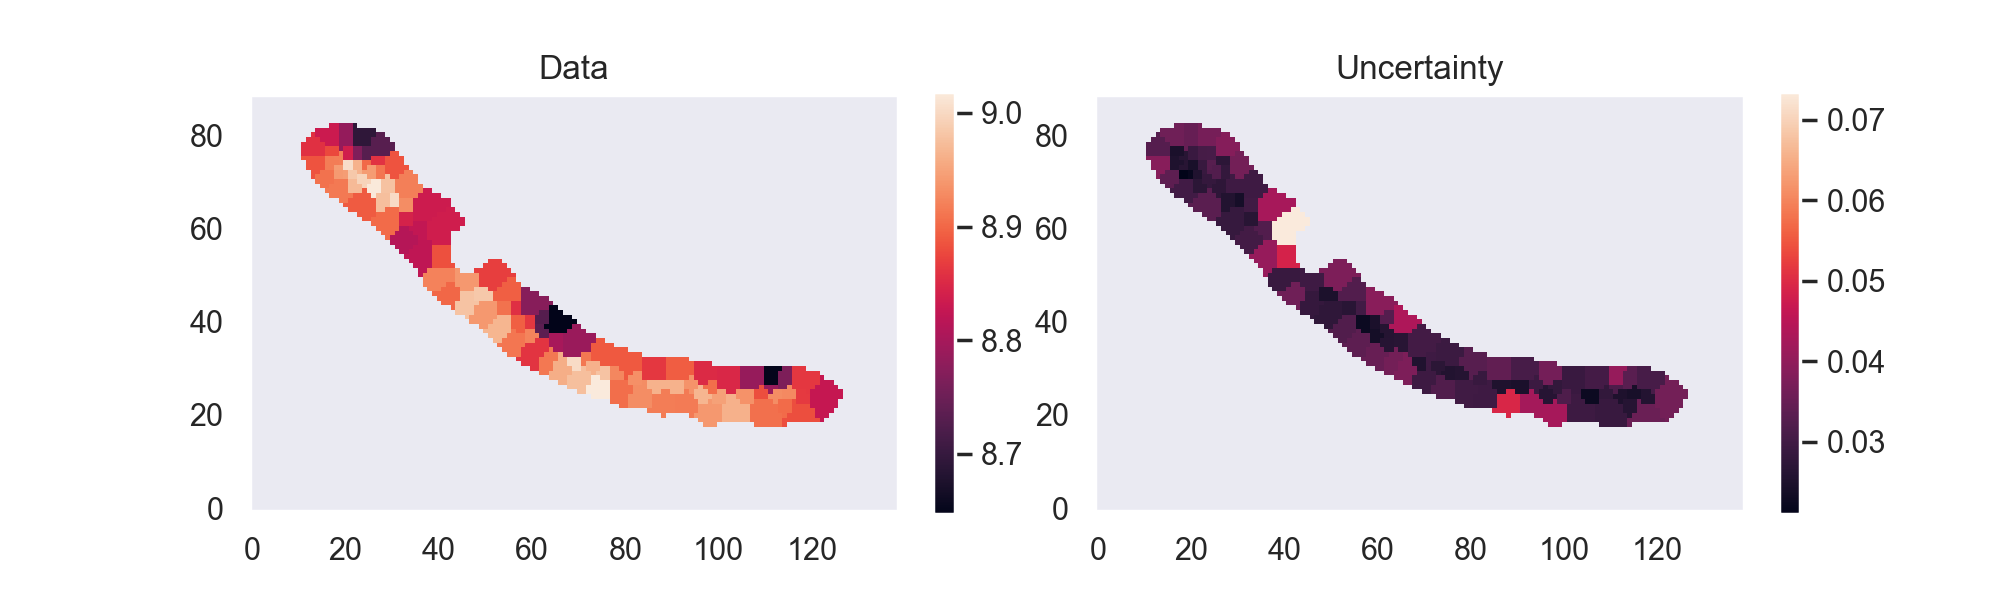

In [2]:
obs = Observation(z=0.725,
                  data_path='Maps/Map_metallicity.fits',
                  unc_path='Maps/Map_metallicity_unc.fits',
                  seeing = 0.7/0.2)

obs.plot()

model = Metallicity_Gradient(zlens=0.375,
              dfx_path='../../Data/Lensing/A370/lens_model/dplx_norm_alignhead.fits',
              dfy_path='../../Data/Lensing/A370/lens_model/dply_norm_alignhead.fits',
              df_ang = 90.)

model.create_projection_maps(obs,correct_z=True)

## Model with GALFIT Morphology

    COMMENT ========== GALFIT Input Parameters ==========
    INITFILE= 'galaxy_input'       / GALFIT input file
    BANDS   = '1       '           / Band labels
    WL_1    =            15369.176 / Band wavelength
    DATAIN_1= 'SP_A370_F160_head.fits' / Input data image
    SIGMA_1 = 'SP_A370_F160W_head_sigma.fits' / Input sigma image
    PSF_1   = 'SP_A370_F160W_head_psf_shift.fits ' / Convolution PSF and kernel
    MASK_1  = 'SP_A370_F160W_head_mask.fits' / Input mask image
    MAGZPT_1=              25.6663 / Magnitude zeropoint
    CONSTRNT= 'galaxy_constr'      / Parameter constraint file
    FITSECT = '[1:1000,1:1000]'    / Image section fitted
    CONVBOX = '1024, 1024'         / Convolution box size
    MINSIGMA=                   0. / Min. sigma factor
    NITER   =                  254 / Number of iterations
    FIRSTCON=                   -1 / First constrained iteration
    LASTCON =                   -1 / Last constrained iteration
    COMMENT ========== GALFIT Final Parameters ==========
    COMP_1  = 'sersic  '           / Component type
    1_XC    = '531.6807 +/- 0.0284' / X center [pixel]
    1_YC    = '545.6168 +/- 0.0538' / Y center [pixel]
    1_MAG   = '20.6878 +/- 0.0180' / Integrated magnitude [mag]
    1_RE    = '34.9528 +/- 0.3851' / Effective radius Re [pixels]
    1_N     = '1.1774 +/- 0.0083'  / Sersic index
    1_AR    = '0.3243 +/- 0.0009'  / Axis ratio (b/a)
    1_PA    = '-30.6479 +/- 0.1212' / Position Angle (PA) [degrees: Up=0, Left=90]
    COMMENT ------------------------------------------------------------------------
    COMP_2  = 'sersic  '           / Component type
    2_XC    = '530.6668 +/- 0.0301' / X center [pixel]
    2_YC    = '539.0006 +/- 0.0235' / Y center [pixel]
    2_MAG   = '18.1666 +/- 0.0016' / Integrated magnitude [mag]
    2_RE    = '99.5097 +/- 0.1764' / Effective radius Re [pixels]
    2_N     = '1.0000 +/- 0.0020'  / Sersic index
    2_AR    = '0.3165 +/- 0.0004'  / Axis ratio (b/a)
    2_PA    = '-51.8797 +/- 0.0349' / Position Angle (PA) [degrees: Up=0, Left=90]
    COMMENT ------------------------------------------------------------------------
    COMP_3  = 'sky     '           / Component type
    3_XC    = '[500.5000]'         / X center [pixel]
    3_YC    = '[500.5000]'         / Y center [pixel]
    3_SKY   = '1.825e-03 +/- 9.465e-06' / Sky background [ADUs]
    3_DSDX  = '1.179e-05 +/- 9.715e-08' / x sky gradient [ADUs]
    3_DSDY  = '-5.732e-06 +/- 8.290e-08' / y sky gradient [ADUs]
    COMMENT ------------------------------------------------------------------------
    VERSION = 'galfitm-1.2.0'      / galfitm version
    CHISQ   =     4330486.76085207 / Chi^2 of fit
    NDOF    =               102998 / Degrees of freedom
    NFREE   =                   17 / Number of free parameters
    NFIX    =                    0 / Number of fixed parameters
    CHI2NU  =     42.0443771806449 / Reduced Chi^2
    LOGFILE = 'galaxy_gf1.galfit.03' / Output logfile
    COMMENT =============================================


**Main component: component 2 (ext 4)**

<IPython.core.display.Javascript object>


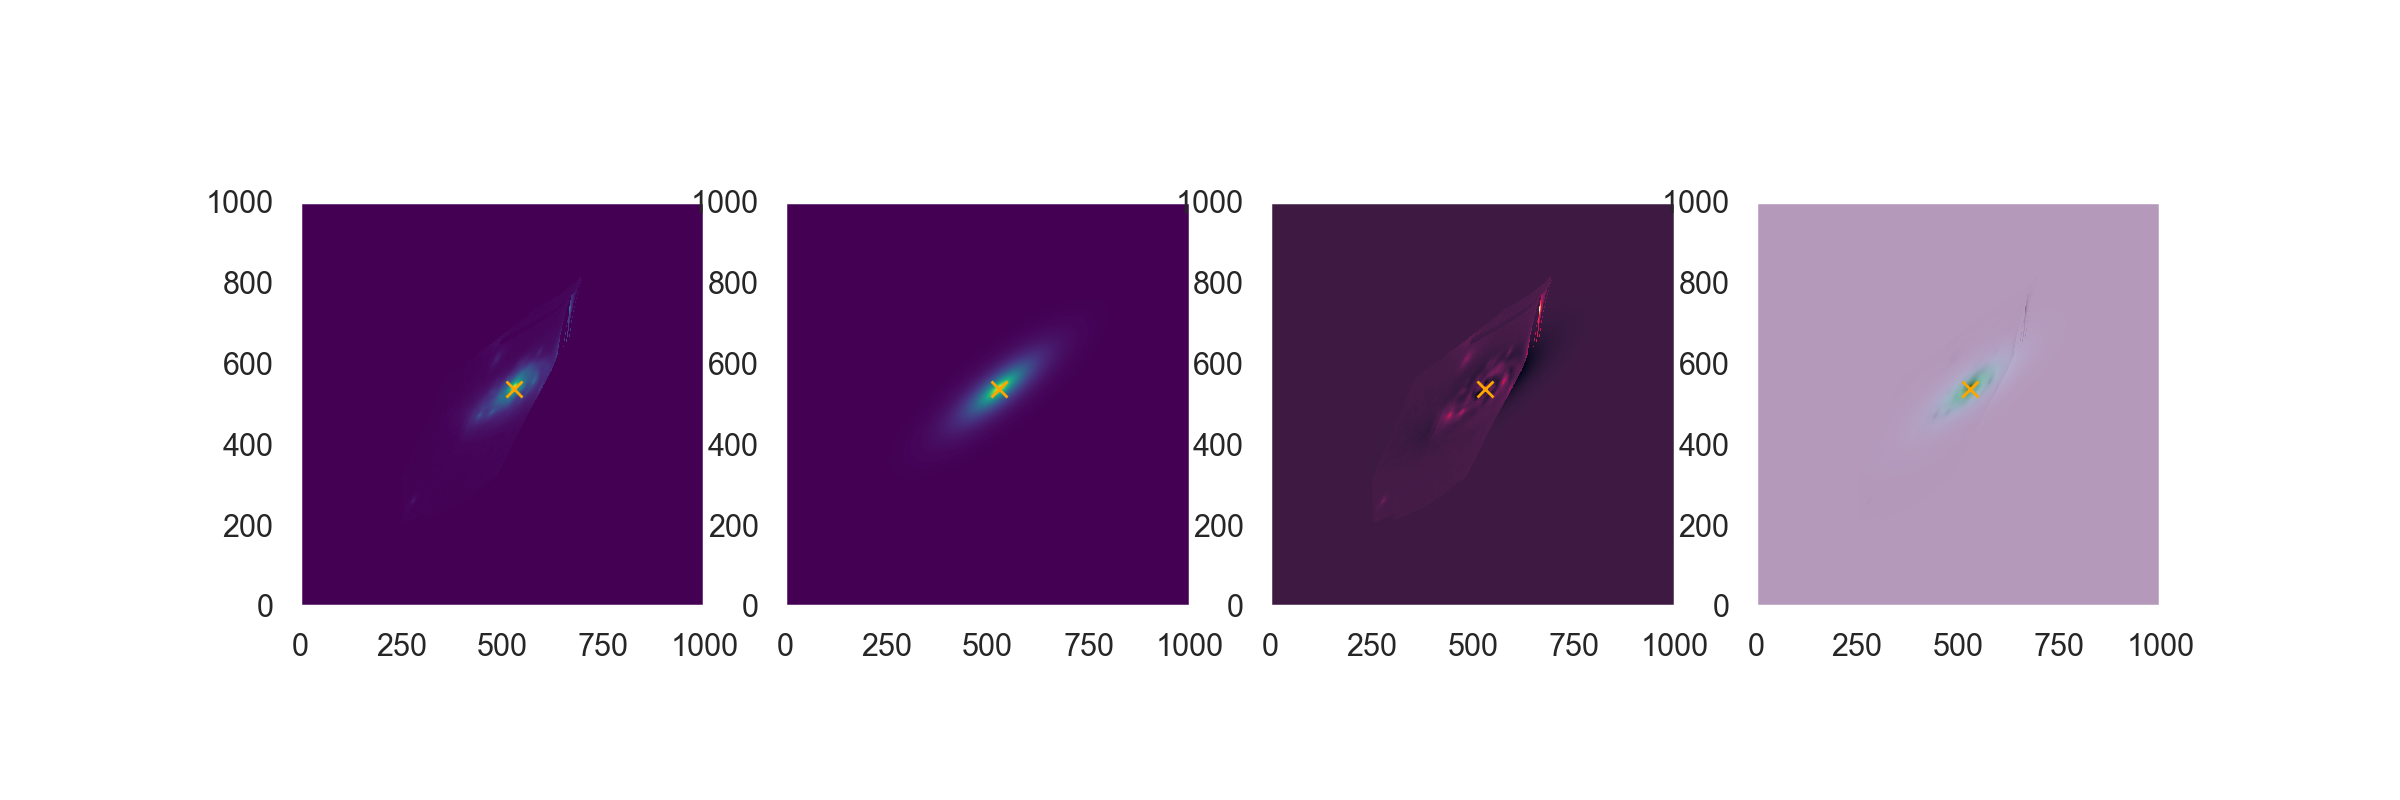

(array([537]), array([529]))


In [3]:
galfit_input = fits.getdata('../../Data/Galfit/A370_galfit1.fits',ext=0)
galfit_model = fits.getdata('../../Data/Galfit/A370_galfit1.fits',ext=4)
galfit_res = fits.getdata('../../Data/Galfit/A370_galfit1.fits',ext=2)

fig, ax = plt.subplots(1,4,figsize=(12,4))
ax[0].imshow(galfit_input,origin='lower',cmap='viridis')
ax[1].imshow(galfit_model,origin='lower',cmap='viridis')
ax[2].imshow(galfit_res,origin='lower')

ax[3].imshow(galfit_input,origin='lower',cmap='Greys')
ax[3].imshow(galfit_model,origin='lower',cmap='viridis',alpha=0.4)

print(np.where(galfit_model==np.max(galfit_model)))
for x in ax:
    x.plot(529,537,marker='x',color='orange')

fits.writeto('../../Data/Lensing/A370/SP_GALFIT_model.fits',data=galfit_model,header=fits.getheader('../../Data/Galfit/A370_galfit1.fits'),overwrite=True)

<IPython.core.display.Javascript object>


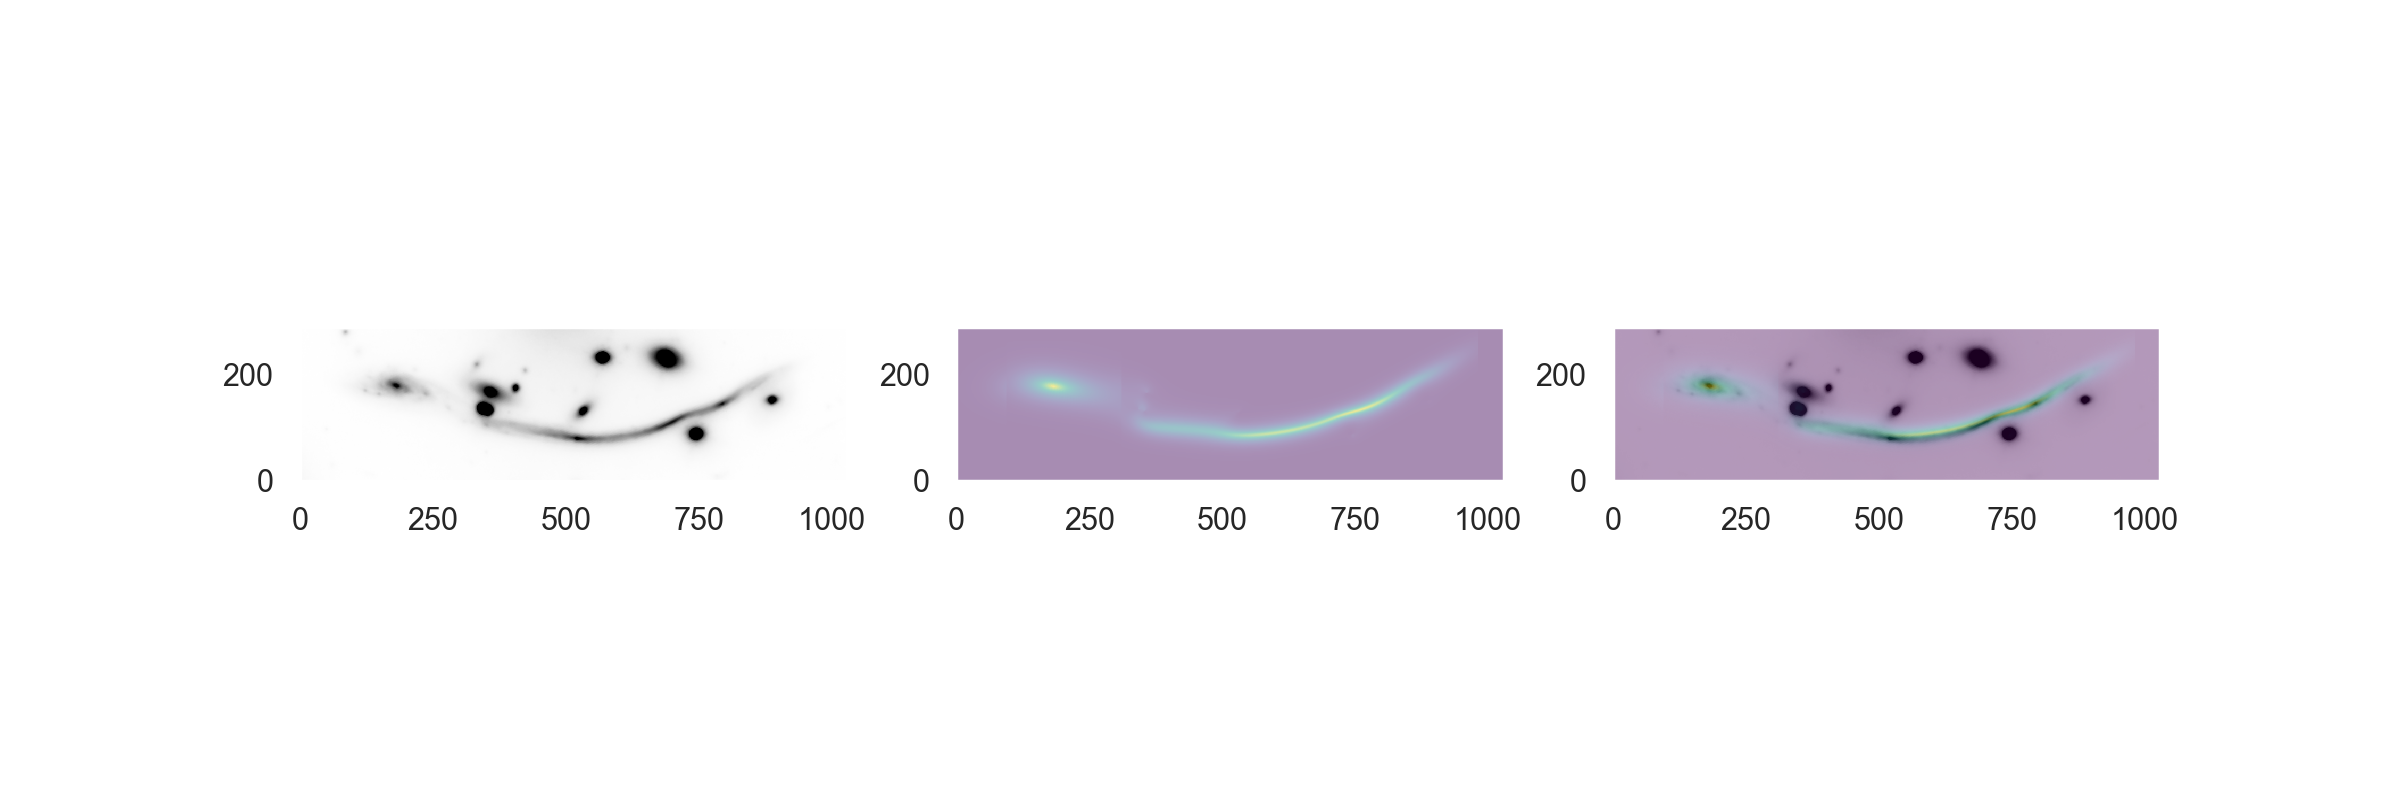

In [4]:
hst_ip = fits.getdata('../../Data/HST/A370_F160w.fits')
galfit_model, _ = reproject_interp('../../Data/Lensing/A370/simul_GALFIT_model.fits',fits.getheader('../../Data/HST/A370_F160w.fits'))

fig, ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(hst_ip,origin='lower',cmap='Greys',vmax=0.2)
ax[1].imshow(galfit_model,origin='lower',alpha=0.4,cmap='viridis')

ax[2].imshow(hst_ip,origin='lower',cmap='Greys',vmax=0.2)
ax[2].imshow(galfit_model,origin='lower',alpha=0.4,cmap='viridis')

centre (array([71]), array([25]))
cx: 25
cy: 71
q: 0.32
pa: -51.88
df_ang: 90.00
z_grad: -0.0200
z_0: 9.0000


<IPython.core.display.Javascript object>


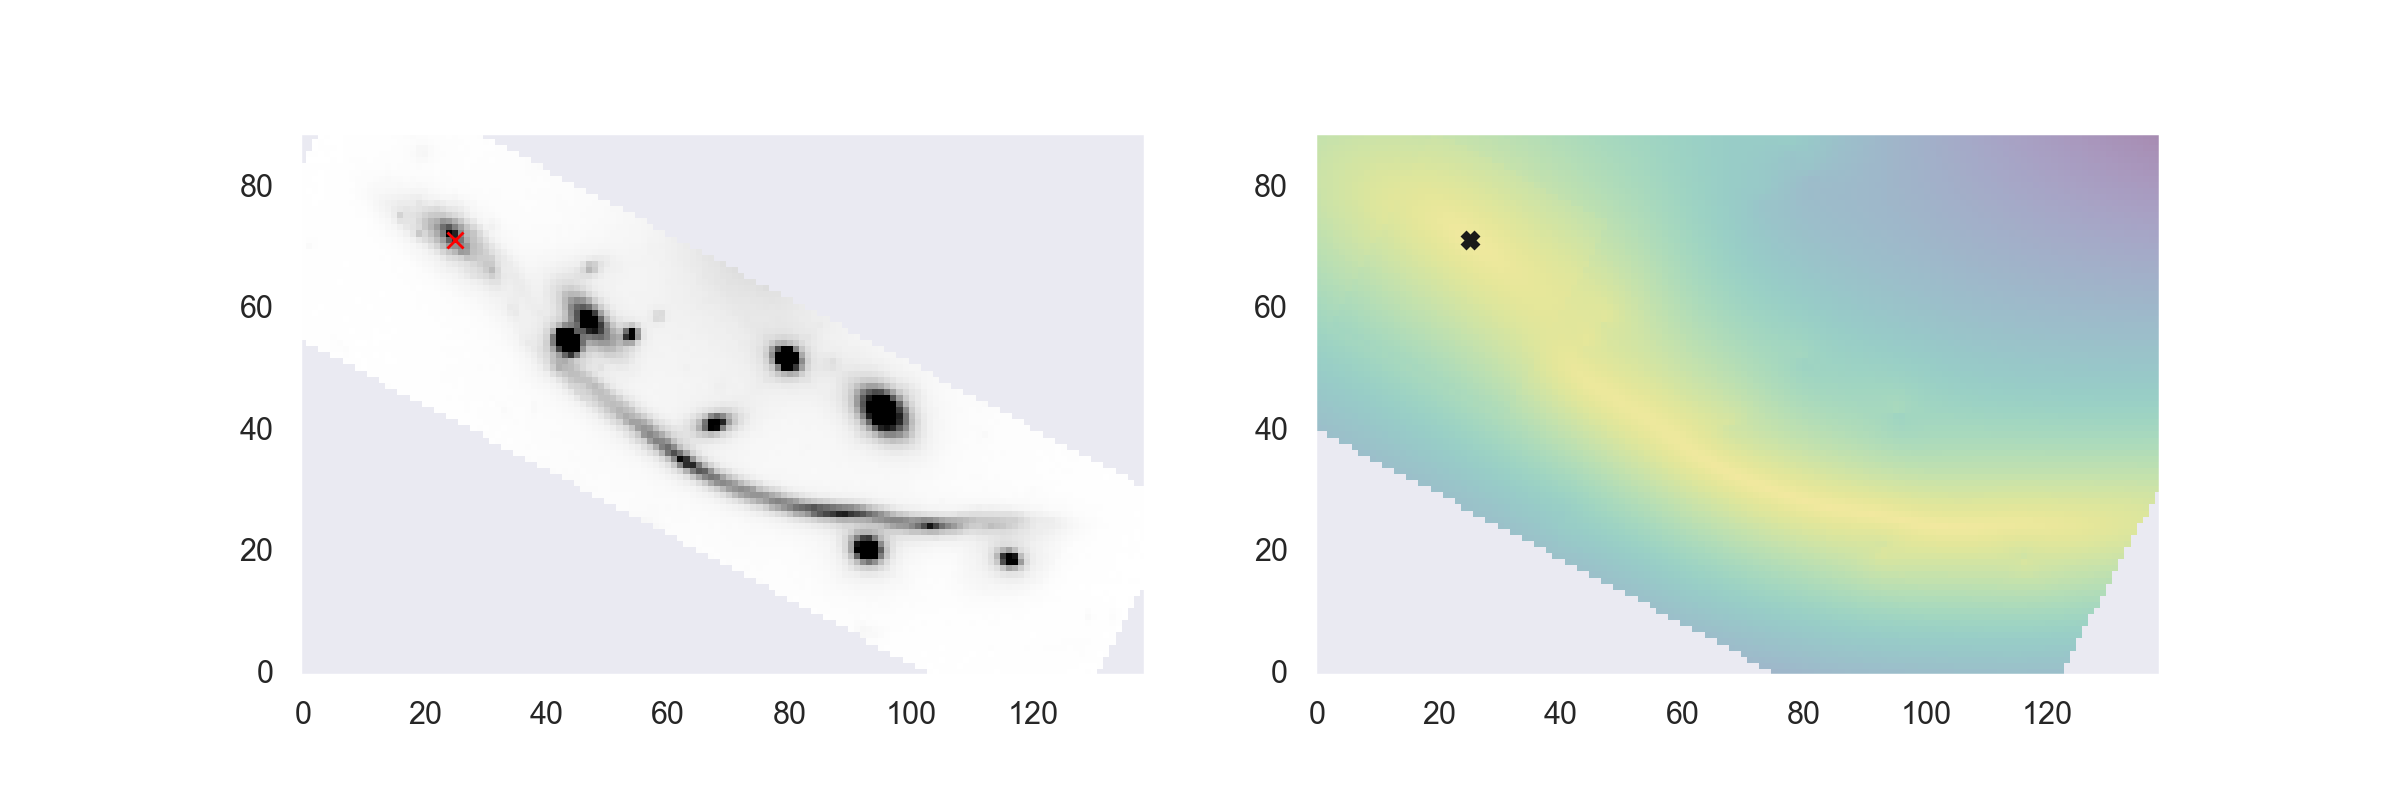

In [5]:
hst, _ = reproject_interp('../../Data/HST/A370_F160w.fits',obs.header)
hst[np.where(hst==0)] = np.nan
galfit_centre, _ = reproject_interp('../../Data/Lensing/A370/simul_GALFIT_model.fits',obs.header)
galfit_centre[np.where(galfit_centre==0)] = np.nan
print('centre',np.where(galfit_centre[:,:40] == np.nanmax(galfit_centre[:,:40])))

model.cx = 25
model.cy = 71
model.q = 0.3165
model.z_grad = -0.02
model.z_0 = 9.0
model.pa = -51.8797
model.print_parameter_values()

more_sensible_model = model.make_model()
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(hst,origin='lower',cmap='Greys',vmax=0.2)
#ax[0].imshow(galfit_centre,origin='lower',alpha=0.3,cmap='viridis')
ax[0].plot(25,71,marker='x',color='red')

#ax[1].imshow(hst,origin='lower',cmap='Greys',vmax=0.3)
ax[1].imshow(more_sensible_model,origin='lower',alpha=0.4,cmap='viridis')
ax[1].plot(25,71,marker='X',color='k')

## Fit with morphology fixed

In [175]:
model.cx = 25
model.cy = 71
model.q = 0.3165
model.pa = -51.8797
input_par = make_input_parameters(name   = ('z_grad', 'z_0'),
                                 value   = (-0.02, 9.0),
                                 minimum = (-0.1, 8.5),
                                 maximum = (0.0, 9.5))

fit = fit_model(obs=obs,
               model=model,
               parameters=input_par,
               outputname='a370_image_plane_morph_fixed',
               nsteps=1500,
               nwalkers=24,
               binning_map='Maps/Map_bins_SN_110_flux_stddev.fits')

Using 24 walkers and fitting ['z_0', 'z_grad']:
MCMCing for 1500 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 13.0082 minutes


<IPython.core.display.Javascript object>


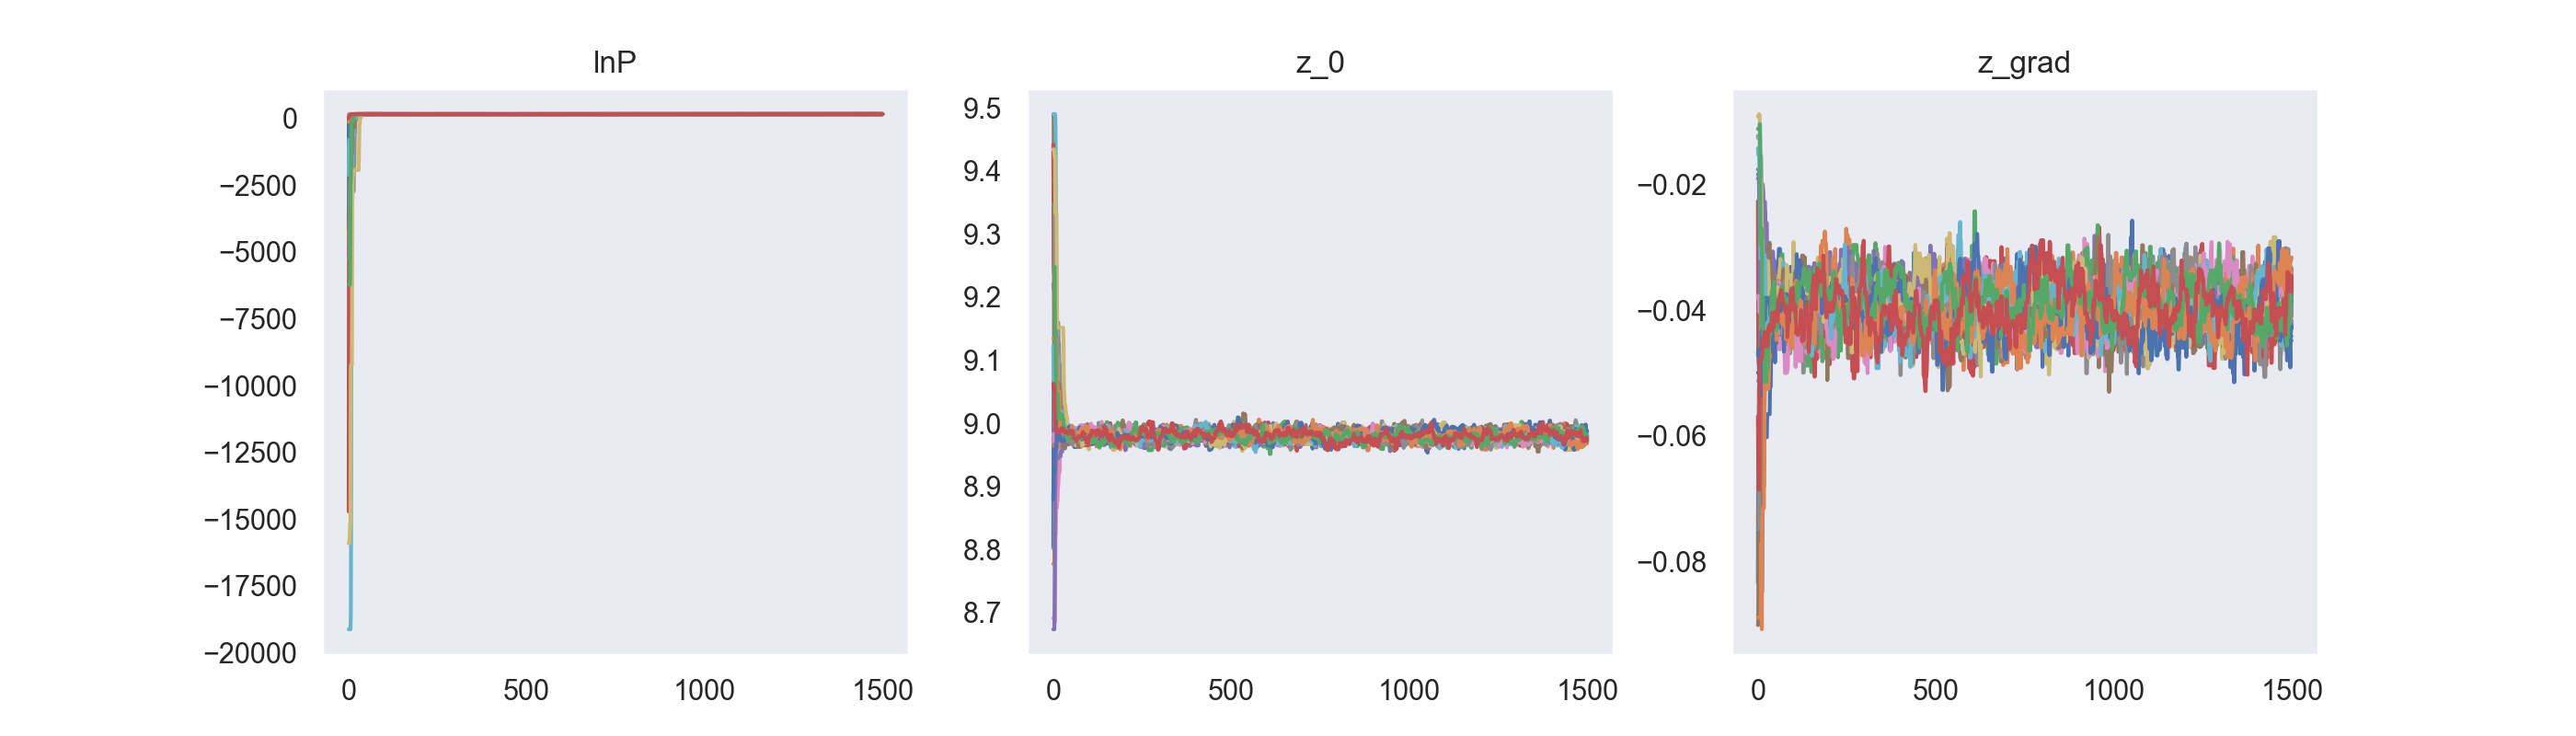

<IPython.core.display.Javascript object>


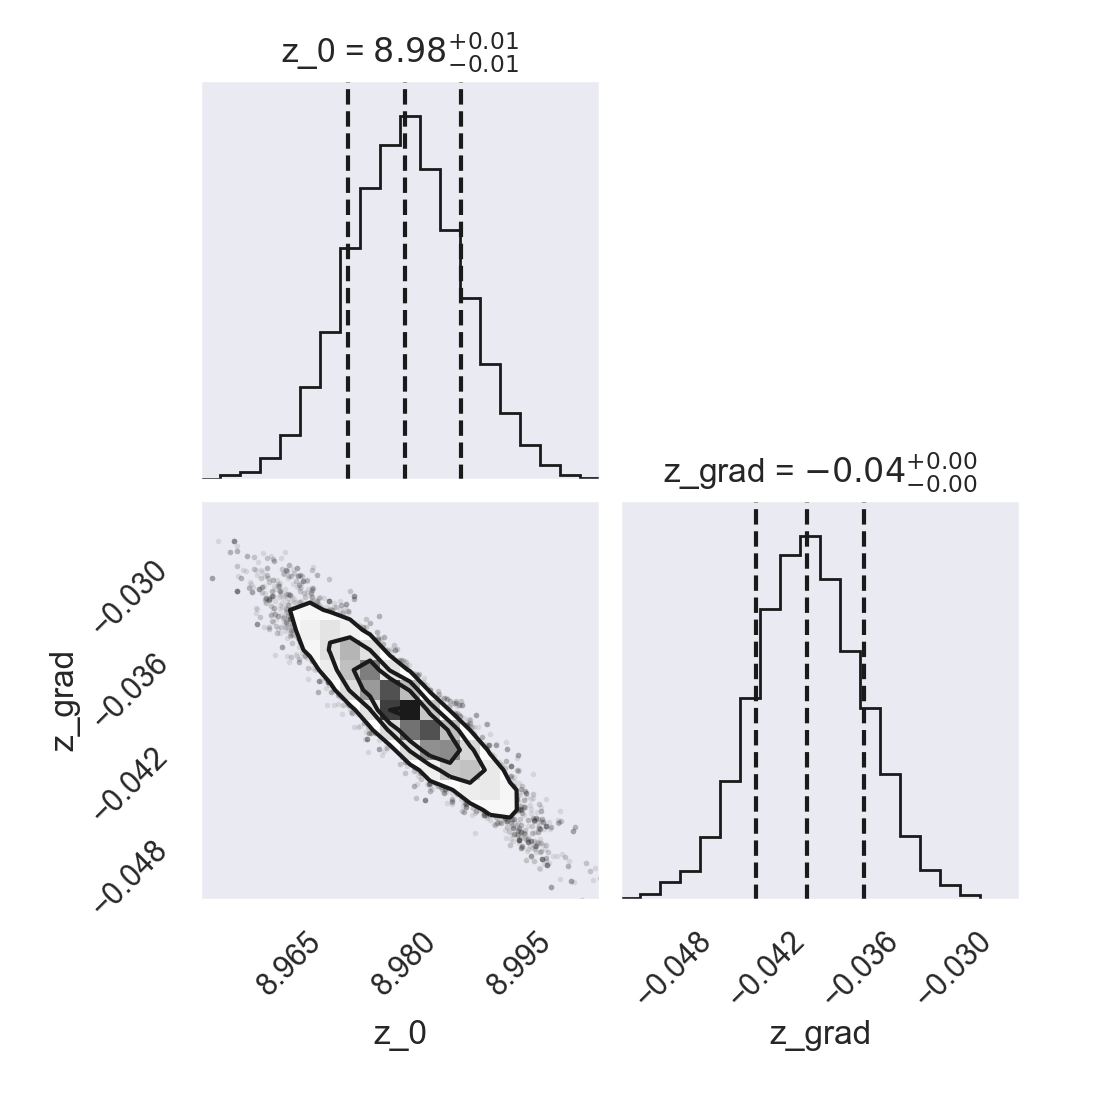

In [6]:
results_fixed_morph = Output('a370_image_plane_morph_fixed')
results_fixed_morph.check_convergence()
results_fixed_morph.make_cornerplot(start=1000)

z_0 8.9800$^{+0.0074}_{-0.0074}$
z_grad -0.0394$^{+0.0037}_{-0.0033}$


<IPython.core.display.Javascript object>


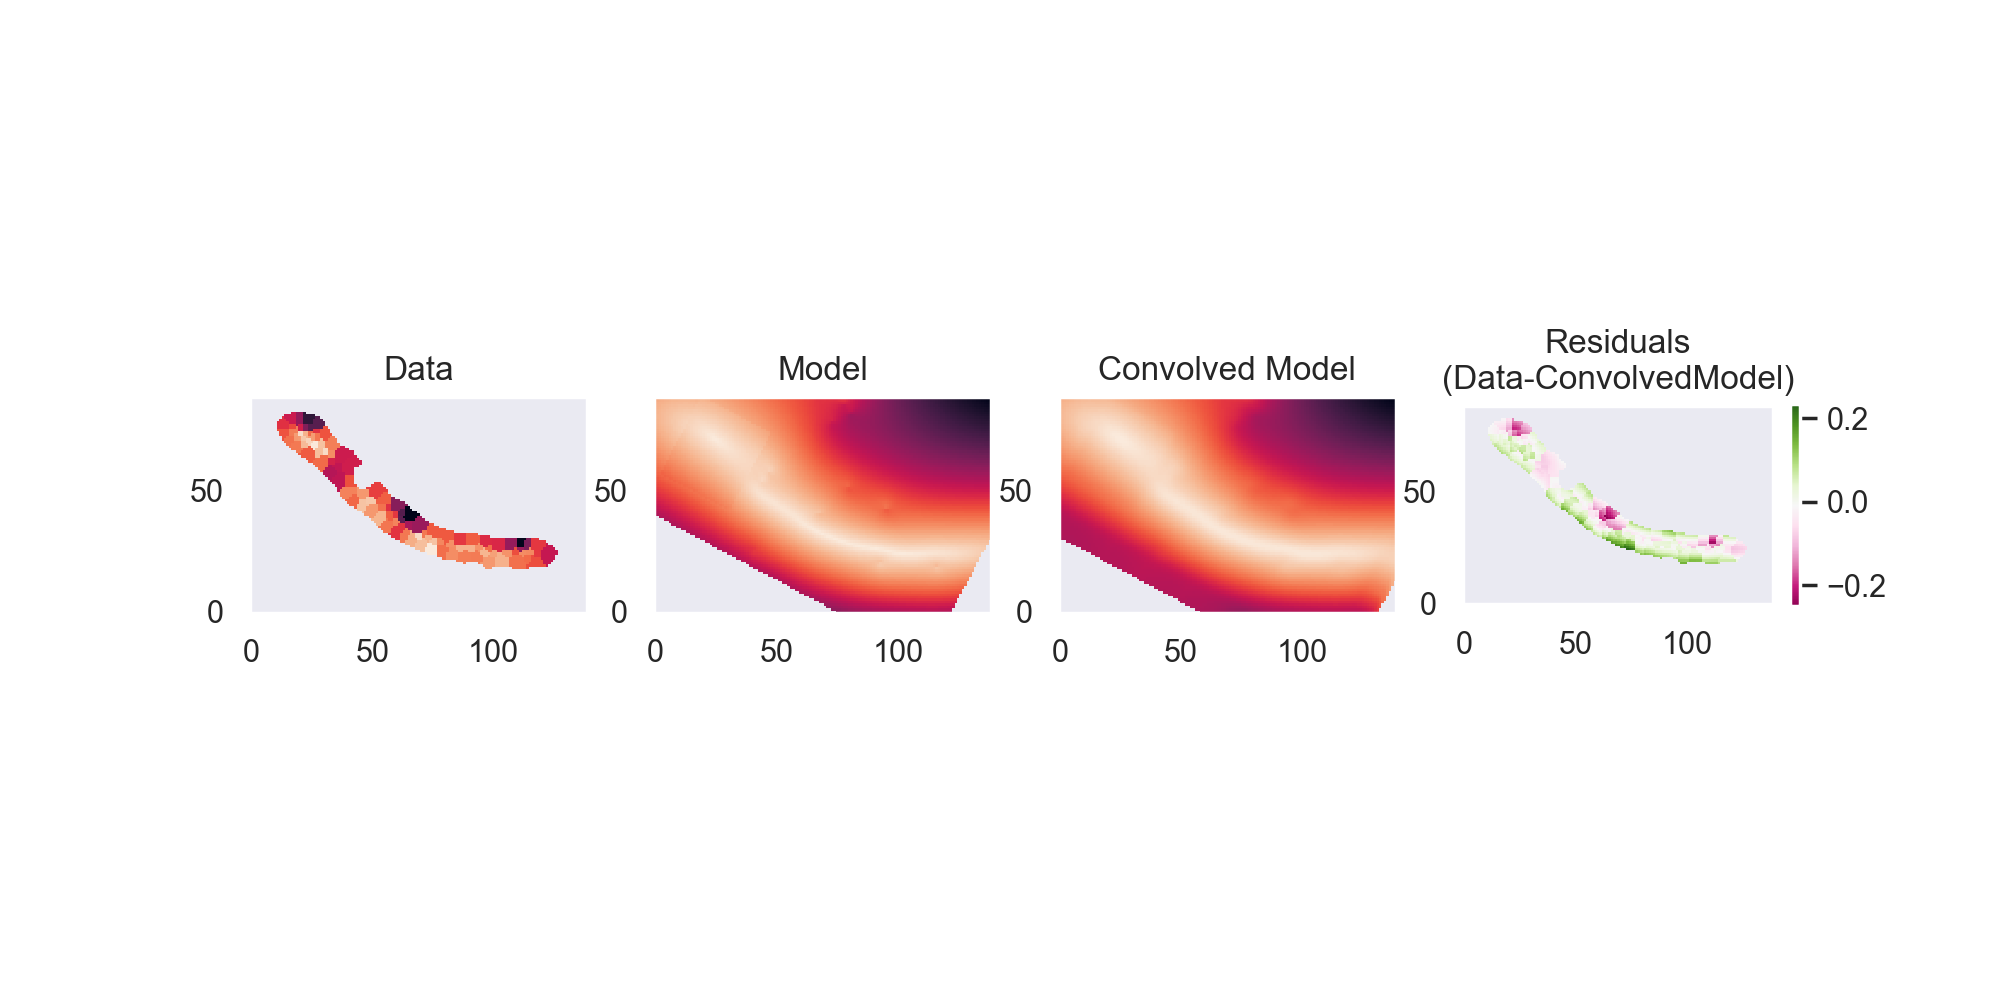

Chi2: 503.09
Chi2/dof: 4.79
Loglikelihood: 170
BIC: -332
Chi2: 8253.72
Chi2/dof: 4.88


In [8]:
best_param_fixed_morph = results_fixed_morph.best_parameters(start=1000)
best_model_fixed_morph, residuals_fixed_morph = results_fixed_morph.plot_solution(best_param_fixed_morph)
chi2_dof = results_fixed_morph.goodness_of_fit(best_param_fixed_morph)

## Write residuals maps
#fits.writeto('Maps/Map_residuals_fixed_morpology.fits',data=residuals_fixed_morph,header=obs.header)

## Real chi2
free_par = 2
chi2_image = (residuals_fixed_morph)**2/obs.unc**2
chi2 = np.nansum(chi2_image[np.where(np.isfinite(chi2_image))])
print('Chi2: %0.2f'%chi2)
print('Chi2/dof: %0.2f'%(chi2/(len(np.where(np.isfinite(obs.data))[0])-free_par)))

## Fit with all parameters free

In [3]:
input_par = make_input_parameters(name    = ('cx', 'cy',  'q', 'pa', 'z_grad', 'z_0'),
                                 value   = (  24,   72,  0.7,   20,    -0.02, 9.0),
                                 minimum = (  19,   50,  0.1,  -90,     -0.1, 8.5),
                                 maximum = (  26,   74,  0.9,   90,      0.0, 9.5))

fit = fit_model(obs=obs,
               model=model,
               parameters=input_par,
               outputname='a370_image_plane',
               nsteps=4000,
               nwalkers=24,
               binning_map='Maps/Map_bins_SN_110_flux_stddev.fits')

Using 24 walkers and fitting ['q', 'z_grad', 'cy', 'pa', 'cx', 'z_0']:
MCMCing for 4000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 93.3606 minutes


<IPython.core.display.Javascript object>


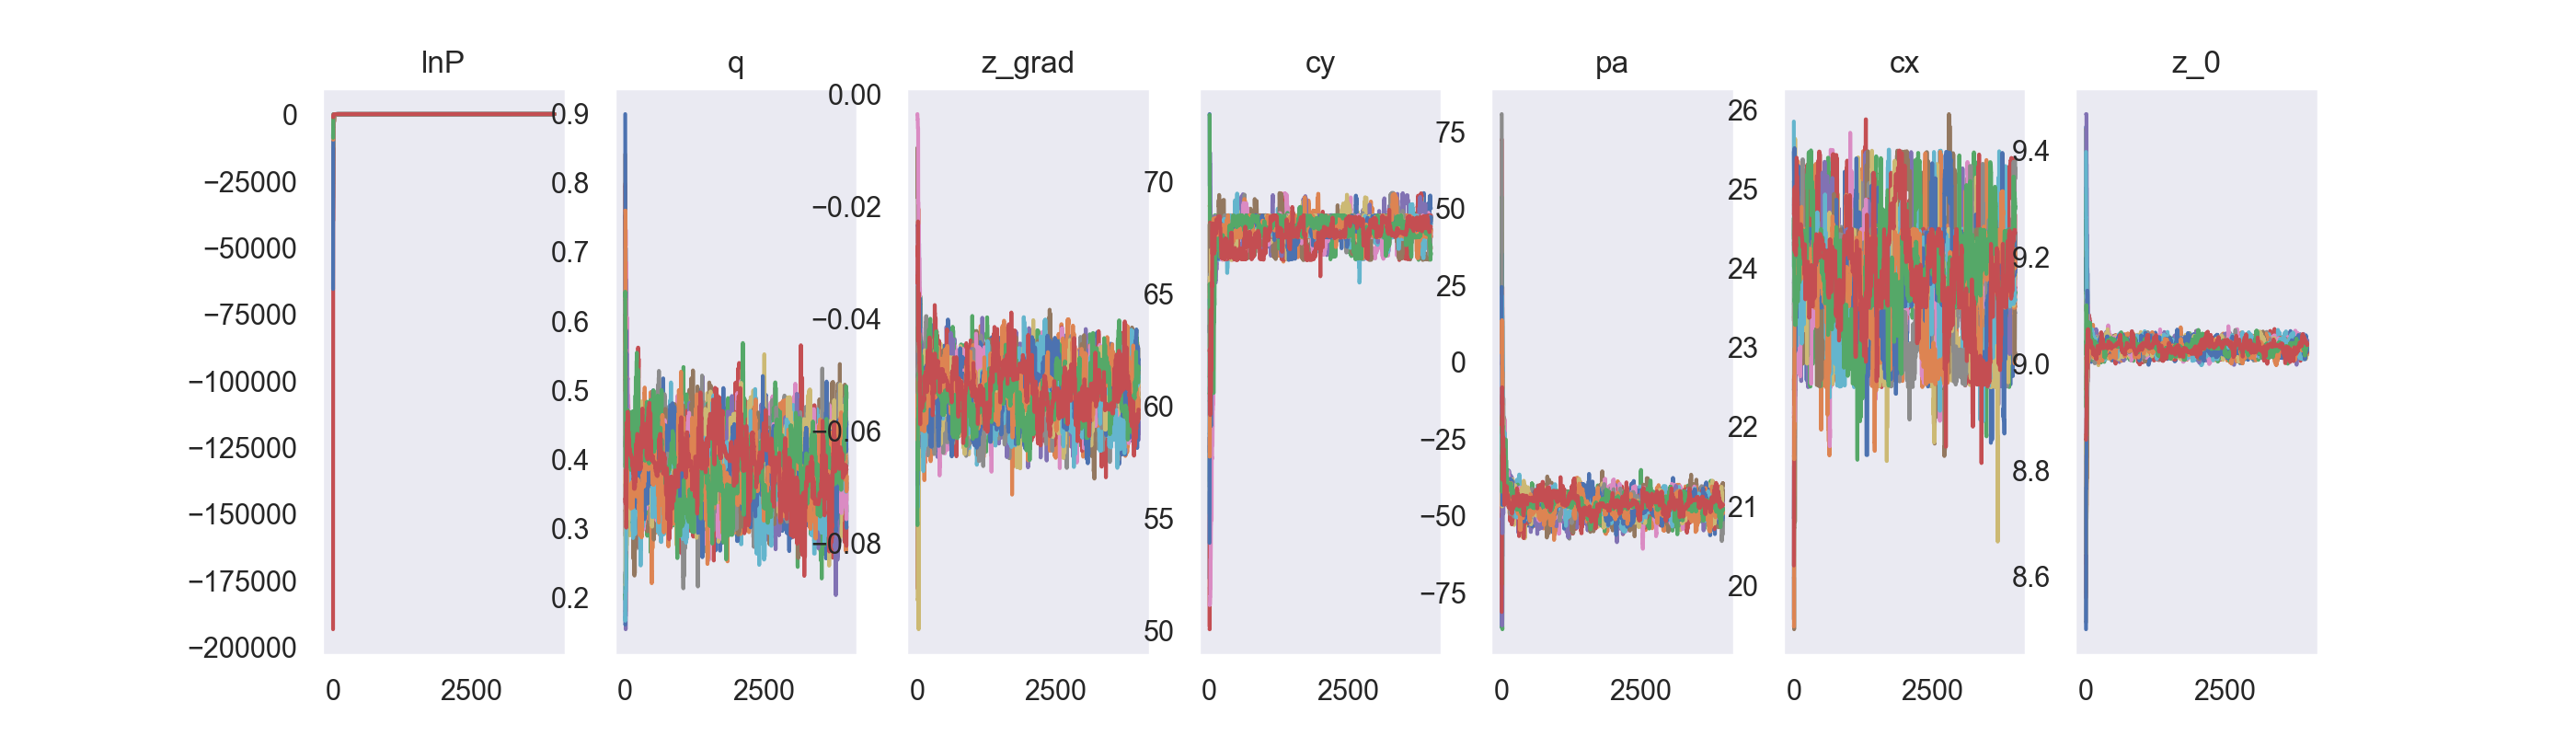

<IPython.core.display.Javascript object>


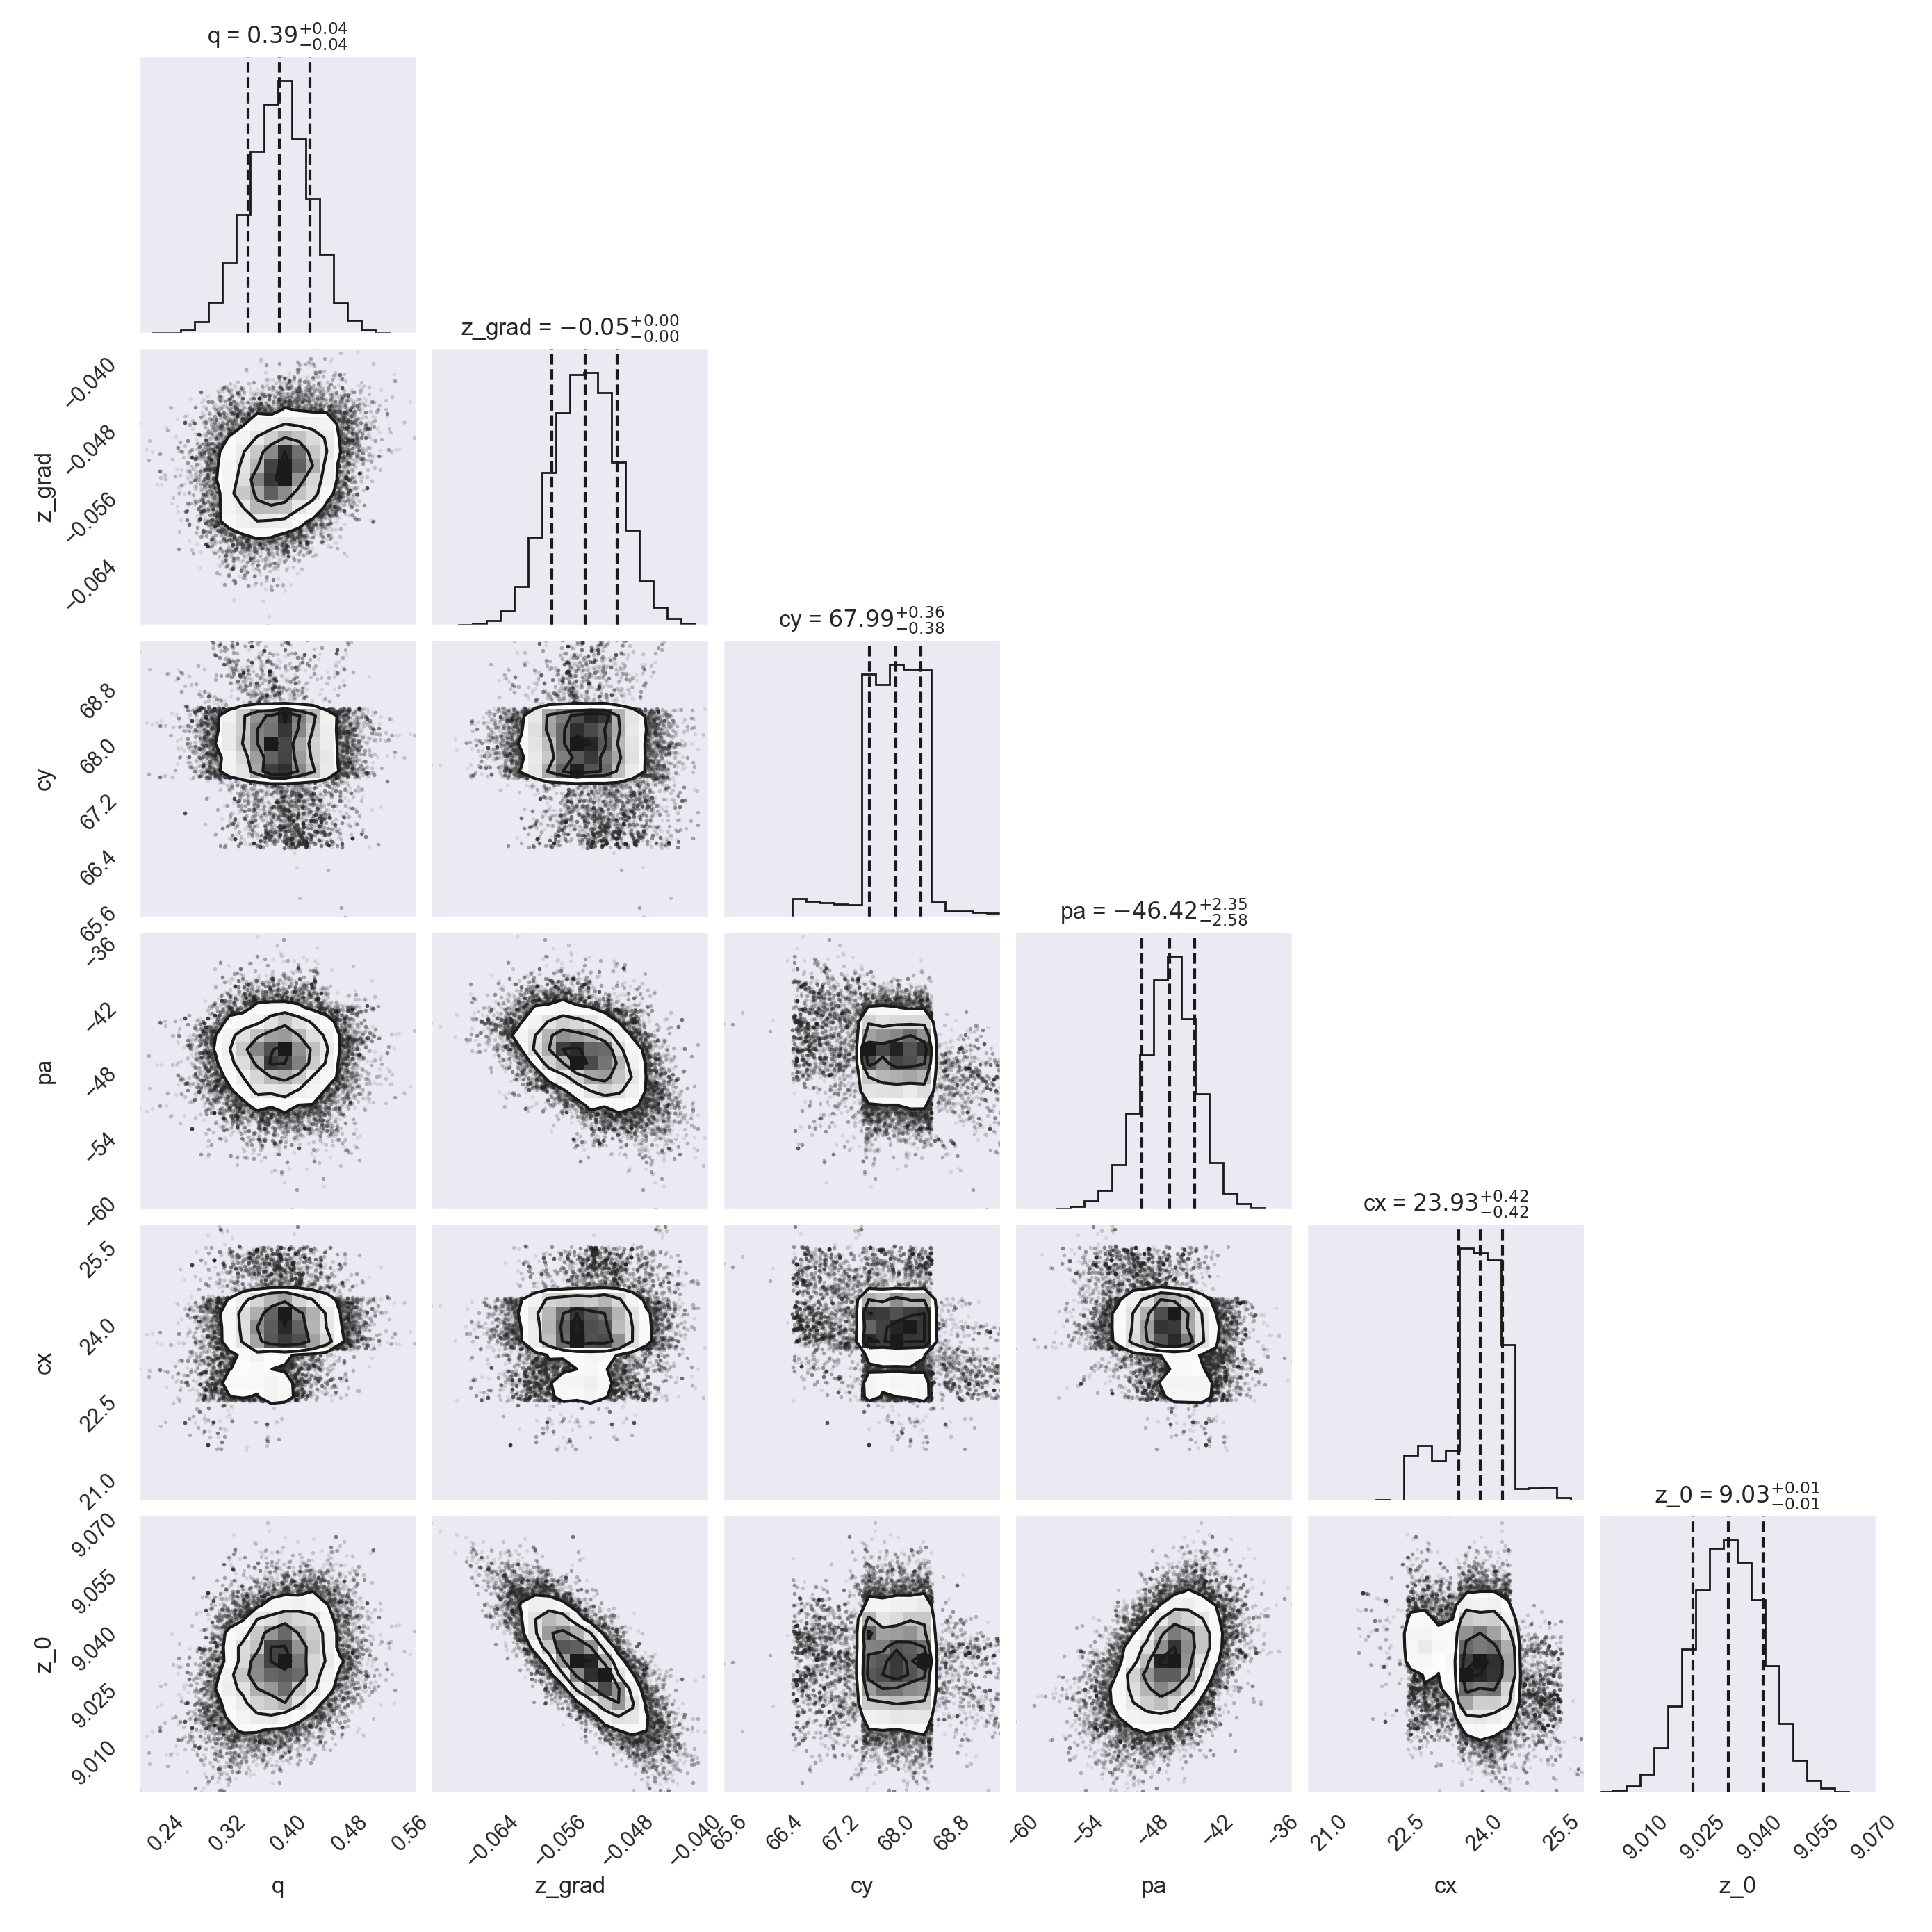

In [9]:
results = Output('a370_image_plane')
results.check_convergence()
results.make_cornerplot(start=1000)

q 0.3880$^{+0.0398}_{-0.0410}$
z_grad -0.0530$^{+0.0038}_{-0.0039}$
cy 67.9861$^{+0.3600}_{-0.3762}$
pa -46.4224$^{+2.3457}_{-2.5814}$
cx 23.9254$^{+0.4228}_{-0.4220}$
z_0 9.0316$^{+0.0092}_{-0.0093}$


<IPython.core.display.Javascript object>


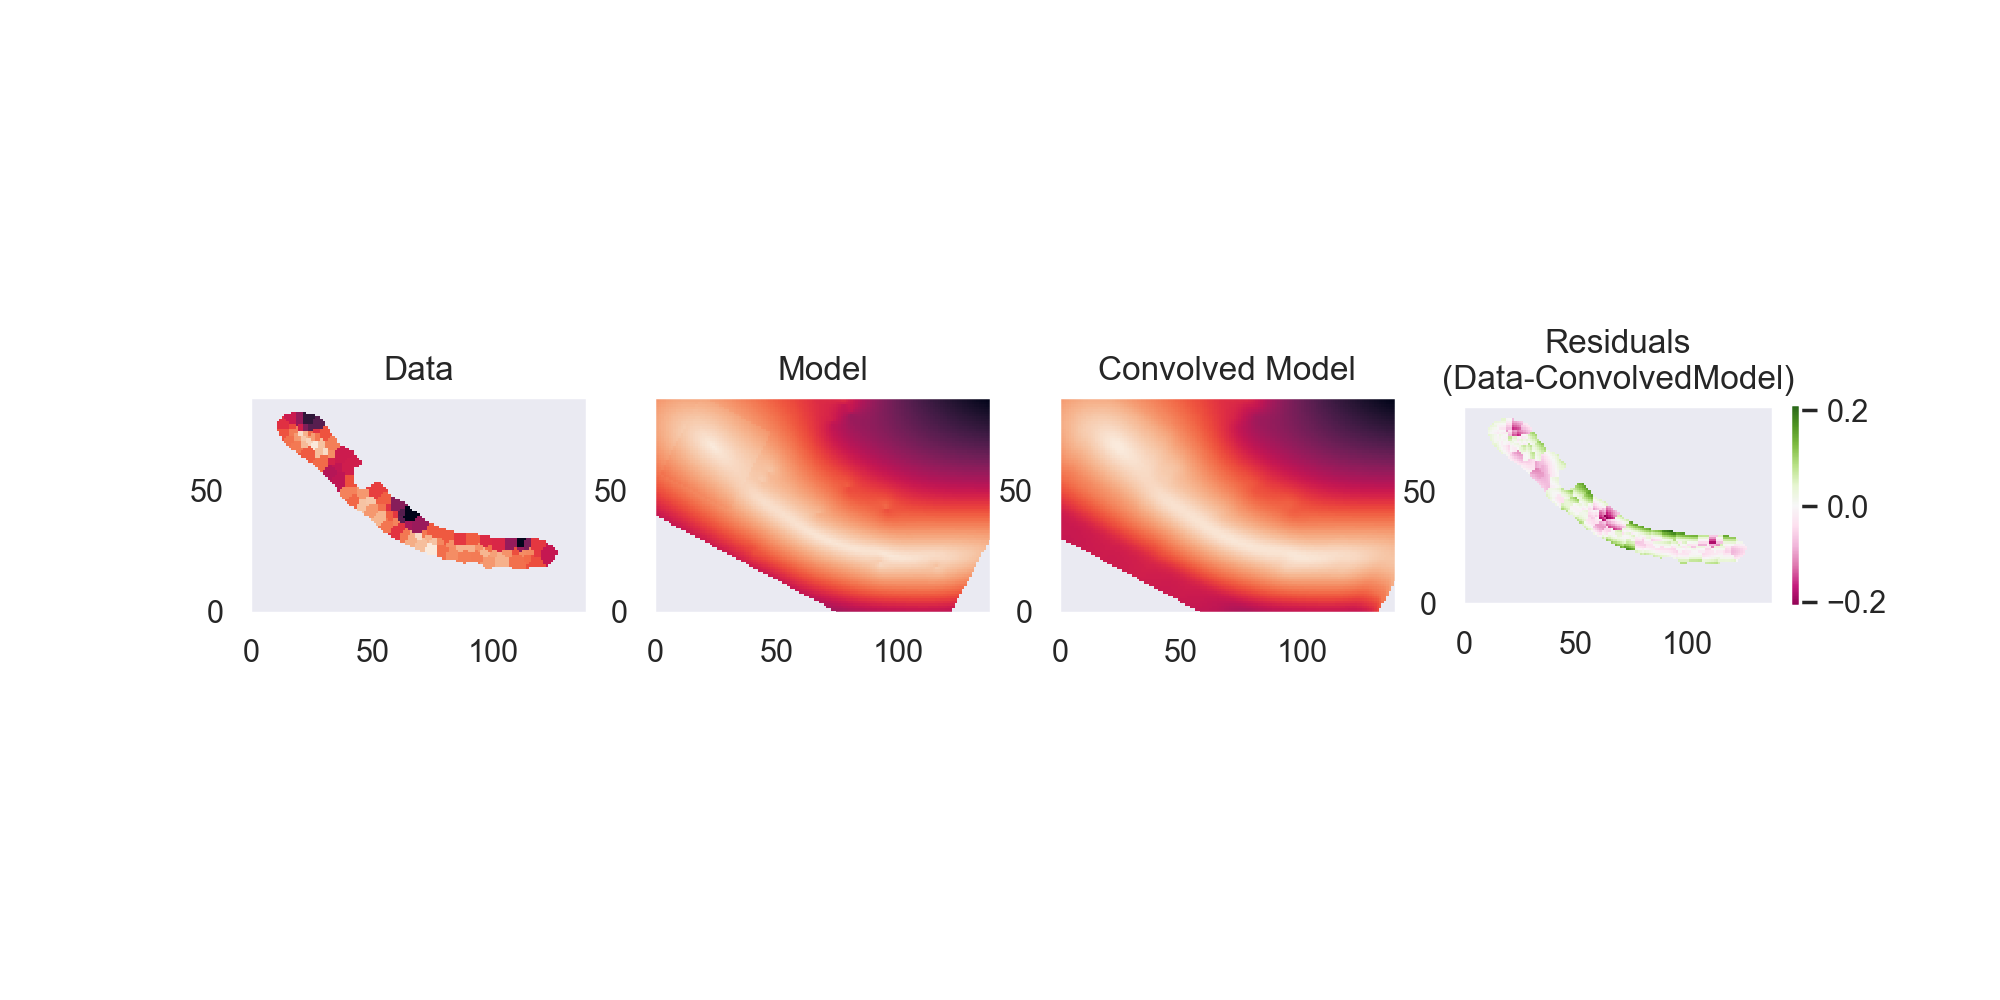

Chi2: 317.26
Chi2/dof: 3.14
Loglikelihood: 263
BIC: -499


In [10]:
best_param = results.best_parameters(start=1000)
best_model, residuals = results.plot_solution(best_param)
chi2_dof = results.goodness_of_fit(best_param)


## Write residuals maps
#fits.writeto('Maps/Map_residuals_free_param.fits',data=residuals,header=obs.header)

<IPython.core.display.Javascript object>


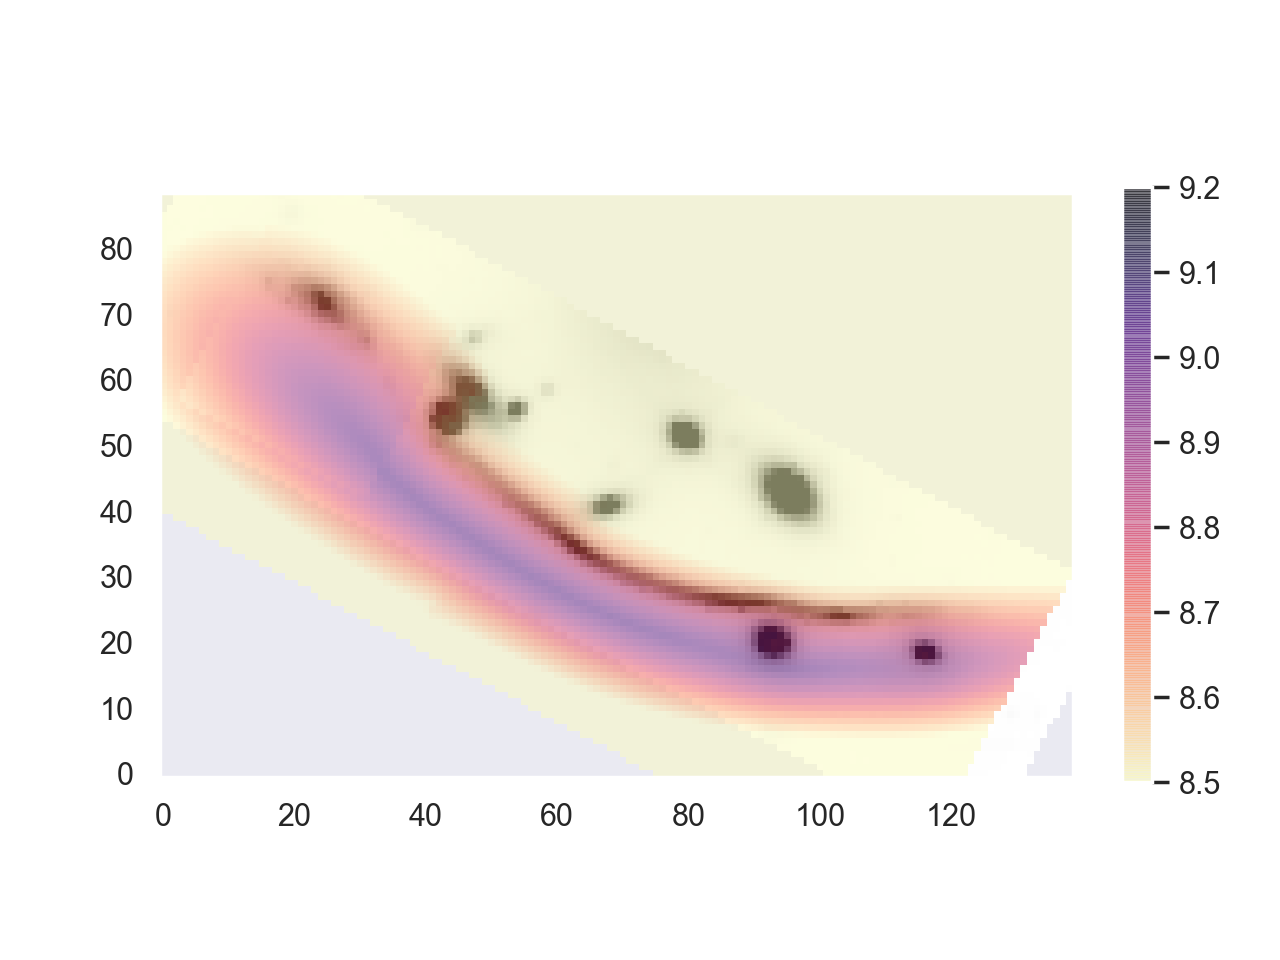

In [13]:
model.q = 0.3880
model.z_grad = -0.0530
model.cx = 67.9861
model.cy = 23.9254
model.z_0 = 9.0316
model.pa = -46.4224

met = model.make_model()

from reproject import reproject_exact
hst,_ = reproject_exact('/Users/vera/MetMaps/Data/HST/A370_F160w.fits',obs.header)


plt.figure()
plt.imshow(hst,origin='lower',vmax=0.15,cmap='Greys')
cax = plt.imshow(met,origin='lower',cmap='magma_r',vmax=9.2,vmin=8.5,alpha=0.5)
plt.colorbar(cax,fraction=0.03)

In [14]:
## Real chi2
free_par = 2
chi2_image = (residuals)**2/obs.unc**2
chi2 = np.nansum(chi2_image[np.where(np.isfinite(chi2_image))])
print('Chi2: %0.2f'%chi2)
print('Chi2/dof: %0.2f'%(chi2/(len(np.where(np.isfinite(obs.data))[0])-free_par)))

Chi2: 6423.15
Chi2/dof: 3.80


In [15]:
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

wcs = WCS('Maps/Map_metallicity.fits')

def to_hsm(x,y):
    ra,dec = wcs.all_pix2world(x,y,1)
    c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)
    print(c.to_string('hmsdms'))
    

to_hsm(25,71)   # Galfit
to_hsm(19,50)
to_hsm(19,74)
to_hsm(26,50)
to_hsm(26,74)
to_hsm(24,68)

print('Galfit centre',wcs.all_world2pix(342.17857919,-44.53251288,1))

02h39m53.7159s -01d35m03.545s
02h39m53.6551s -01d35m07.8167s
02h39m53.8054s -01d35m03.5785s
02h39m53.5727s -01d35m07.1594s
02h39m53.7229s -01d35m02.9213s
02h39m53.7089s -01d35m04.1686s
Galfit centre [array(538446.92823755), array(-2306934.12381291)]


## Masking the 'tail' (only fitting the head)

<IPython.core.display.Javascript object>


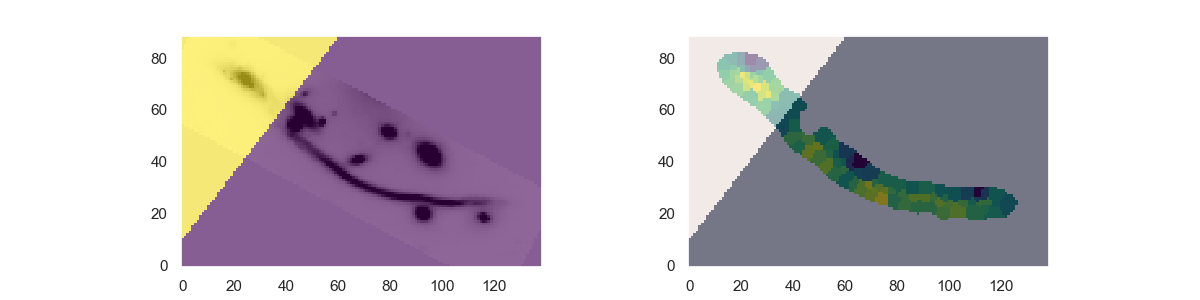

In [12]:
x, y = np.meshgrid(range(hst.shape[0]),range(hst.shape[1]))
mask_head = x > 10 + 1.3*y
mask_head = mask_head.T*1

fig, ax = plt.subplots(1,2,figsize=(12,3))
ax[0].imshow(hst,origin='lower',cmap='Greys',vmax=0.1)
ax[0].imshow(mask_head,origin='lower',cmap='viridis',alpha=0.6)

ax[1].imshow(obs.data,origin='lower',cmap='viridis')
ax[1].imshow(mask_head,alpha=0.5,origin='lower')

In [20]:
input_par = make_input_parameters(name    = ('cx', 'cy',  'q', 'pa', 'z_grad', 'z_0'),
                                 value   = (  24,   72,  0.7,   20,    -0.02, 9.0),
                                 minimum = (  19,   60,  0.1,  -90,     -0.1, 8.5),
                                 maximum = (  27,   76,  0.9,   90,      0.0, 9.5))

fit = fit_model(obs=obs,
               model=model,
               parameters=input_par,
               outputname='a370_image_plane_only_head',
               nsteps=4000,
               nwalkers=24,
               binning_map='Maps/Map_bins_SN_110_flux_stddev.fits',
               mask=mask_head)

Masking data
Using 24 walkers and fitting ['q', 'z_grad', 'cy', 'pa', 'cx', 'z_0']:
MCMCing for 4000 steps
0 %
10 %
20 %
40 %
80 %
Execution time: 33.1730 minutes


In [13]:
results_head = Output('a370_image_plane_only_head')
results_head.check_convergence()
results_head.make_cornerplot(start=1000)

IOError: [Errno 2] No such file or directory: 'a370_image_plane_only_head.pickle'

q 0.1978$^{+0.0337}_{-0.0319}$
z_grad -0.0178$^{+0.0032}_{-0.0034}$
cy 69.7884$^{+0.4723}_{-0.6877}$
pa -48.3300$^{+1.4544}_{-1.4480}$
cx 23.7025$^{+1.0933}_{-0.8831}$
z_0 9.0480$^{+0.0136}_{-0.0133}$
Masking data


<IPython.core.display.Javascript object>


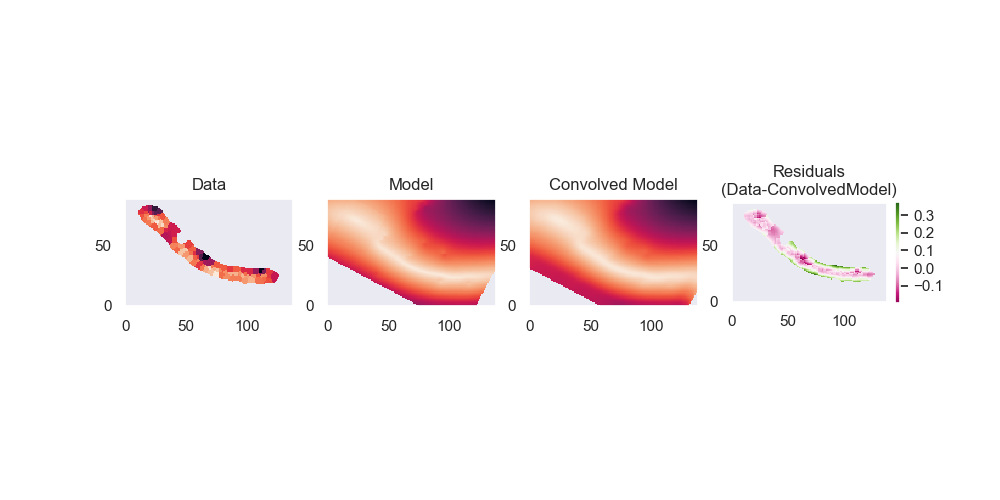

Masking data
Chi2: 559.98
Chi2/dof: 5.54
Loglikelihood: 142
BIC: -256


In [22]:
best_param_head = results_head.best_parameters(start=1000)
best_model_head, residuals_head = results_head.plot_solution(best_param_head)
chi2_dof = results_head.goodness_of_fit(best_param_head)

# Summary

| Name             | dexperkpc | peakmet | cx    | cy    | q      | pa       | chi2/dof | BIC    |
|------------------|-----------|---------|-------|-------|--------|----------|----------|--------|
| All Free         | -0.0208   | 9.0319  | 23.9352    | 68.0169    | 0.3937 | -46.5865    | 3.14 | -499  |
| HST Centre       | -0.0122   | 8.9715  | 24 | 72| 0.4336 | -63.7824    | 5.10    |   -300
| Only Head        | -0.0178   | 9.0480  | 23.7025 | 69.7884 | 0.1978 | -48.3300    | 5.54    | -256  |

<IPython.core.display.Javascript object>


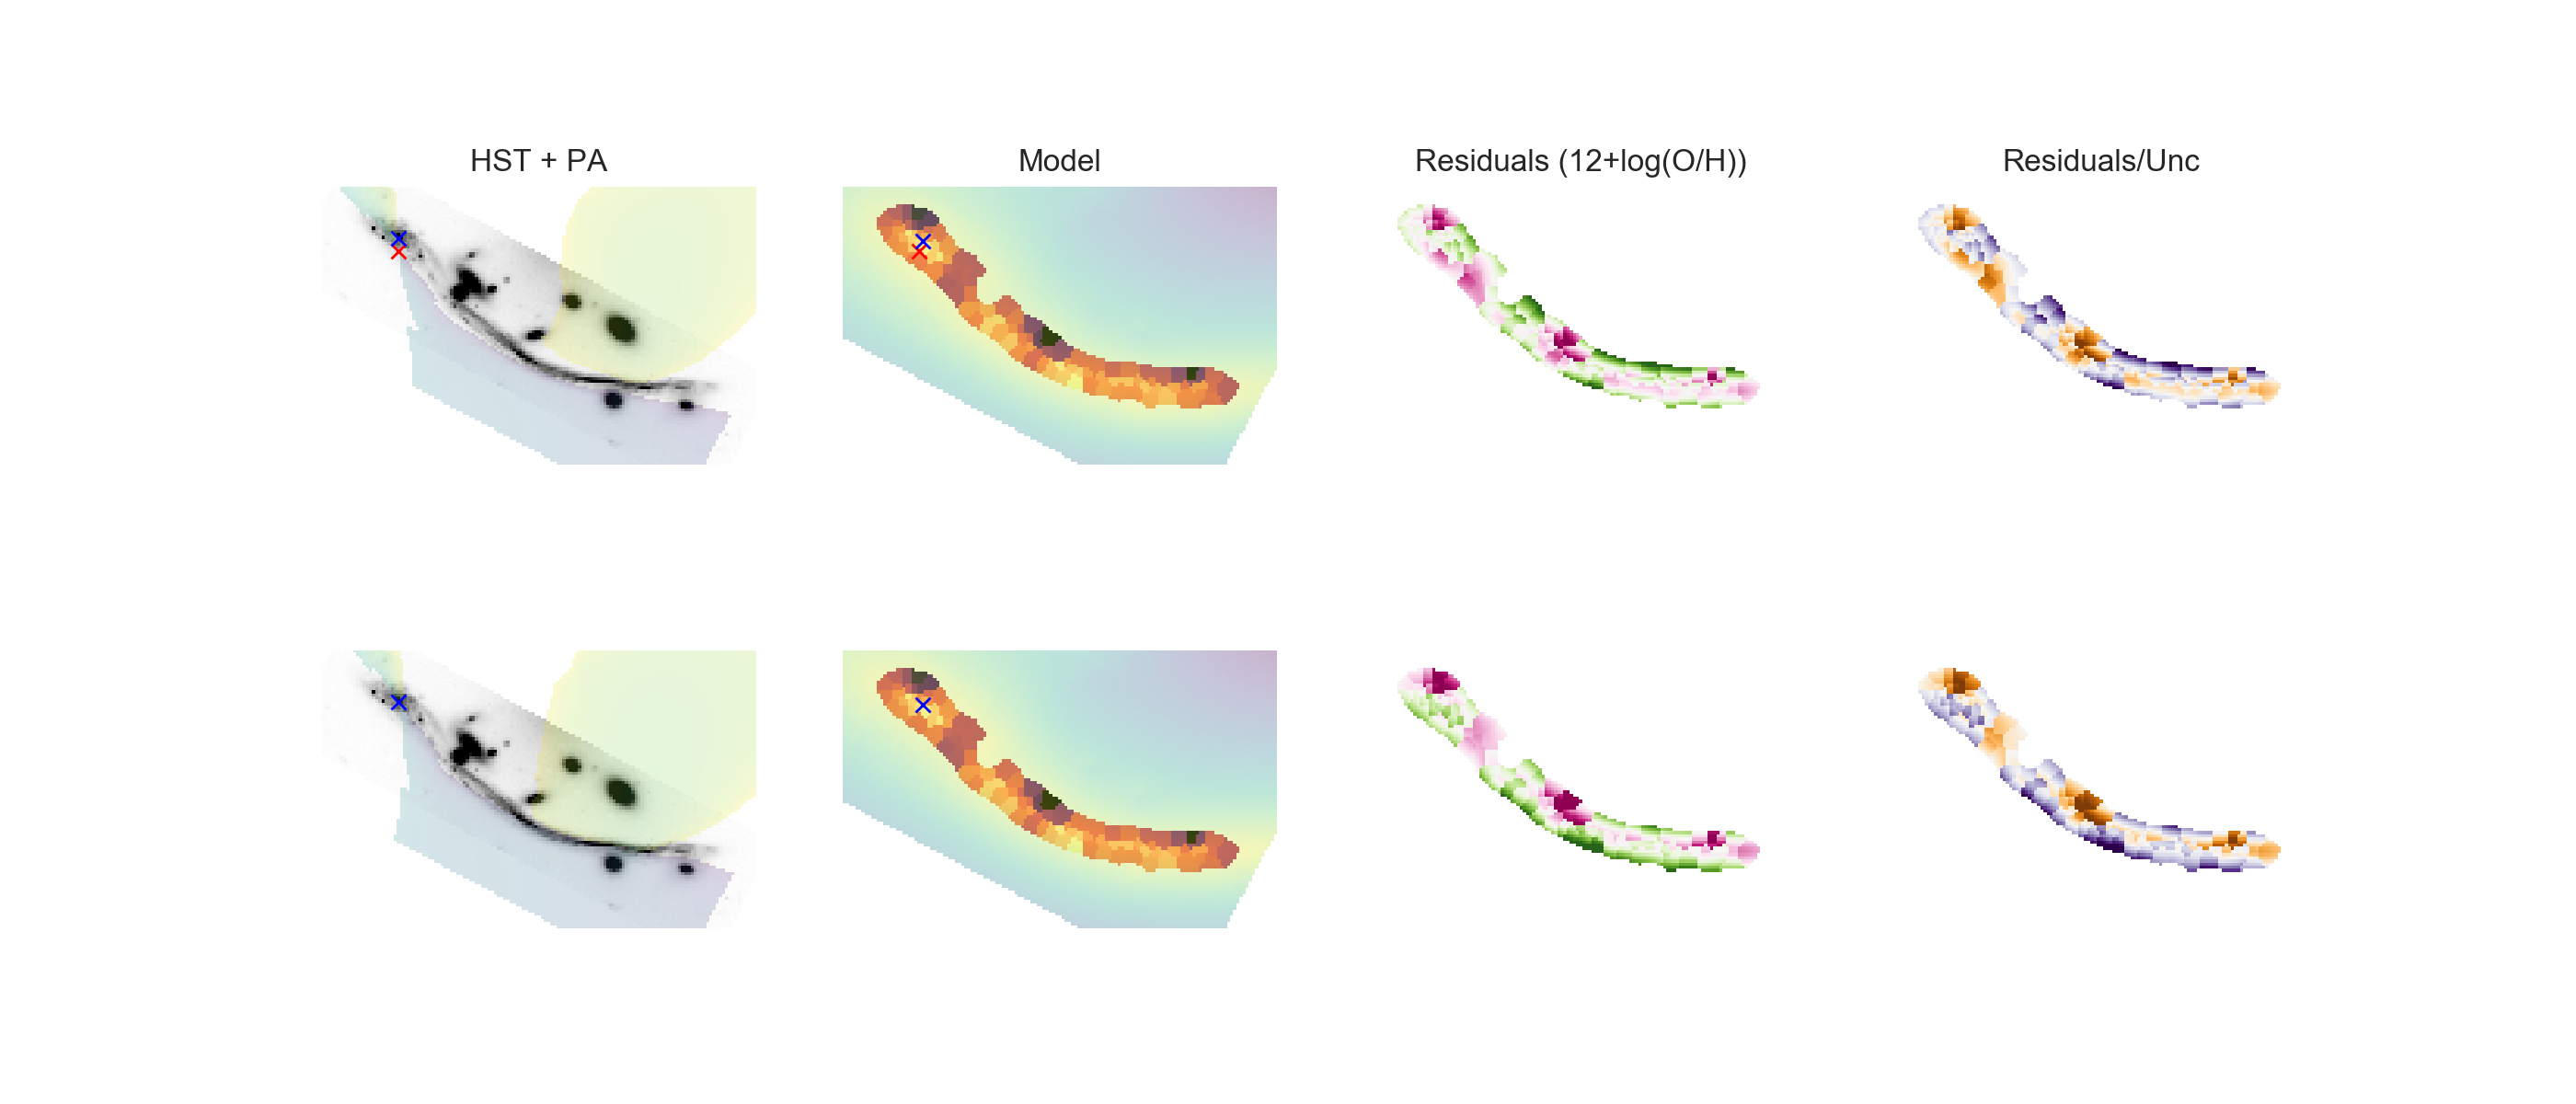

In [16]:
fig, ax = plt.subplots(2,4,figsize=(14,6))
ax = ax.ravel()
hst, _ = reproject_interp('../../Data/HST/A370_F814w.fits',obs.header)

def plot_to_compare(model,residuals,param,ax0,ax1,ax2,ax3):

    ax0.imshow(hst,cmap='Greys',origin='lower',vmax=0.05)
    ang = model.make_azimuthal_map()
    ax0.imshow(ang,cmap='viridis',origin='lower',alpha=0.2)

    try:
        ax0.plot(param['cx']['value'],param['cy']['value'],marker='x',color='red')
    except:
        pass
    ax0.plot(24,72,marker='x',color='blue')
    ax1.imshow(obs.data,cmap='magma',origin='lower')
    ax1.imshow(model.data,cmap='viridis',origin='lower',alpha=0.3)
    try:
        ax1.plot(param['cx']['value'],best_param['cy']['value'],marker='x',color='red')

    except:
        pass
    ax1.plot(25,71,marker='x',color='blue')
    ax2.imshow(residuals,cmap='PiYG',origin='lower',vmin=-0.15,vmax=0.15)
    ax3.imshow(residuals/obs.unc,cmap='PuOr',origin='lower',vmin=-5,vmax=5)
    
plot_to_compare(best_model,residuals,best_param,ax[0],ax[1],ax[2],ax[3])
plot_to_compare(best_model_fixed_morph,residuals_fixed_morph,best_param_fixed_morph,ax[4],ax[5],ax[6],ax[7])

#plot_to_compare(best_model_hst,residuals_hst,best_param_hst,ax[4],ax[5],ax[6],ax[7])
#plot_to_compare(best_model_head,residuals_head,best_param_head,ax[8],ax[9],ax[10],ax[11])

ax[0].set_title('HST + PA')
ax[1].set_title('Model')
ax[2].set_title('Residuals (12+log(O/H))')
ax[3].set_title('Residuals/Unc')

d = [x.axis('off') for x in ax]

## Make 1D plots

In [ ]:
def measure_in_vbins(im,stat):
    if stat == 'mean':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])
    if stat == 'std':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[2] for v in bins ])

def bin_data_r(data,dist):
    binned_data, bin_edges, bin_number = binned_statistic(dist,data,'mean',bins=np.arange(0,10,0.5))
    binned_err, bin_edges, bin_number = binned_statistic(dist,data,'std',bins=np.arange(0,10,0.5))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

def bin_data_ang(data,ang):
    binned_data, bin_edges, bin_number = binned_statistic(ang,data,'mean',bins=range(0,360,20))
    binned_err, bin_edges, bin_number = binned_statistic(ang,data,'std',bins=range(0,360,20))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers


voronoi_map = fits.getdata('Maps/Map_bins_SN_110_flux_stddev.fits')
voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]
size_vbin   = np.array([len(np.atleast_1d(np.where(voronoi_map==v)[0])) for v in bins ])
mult_map = fits.getdata('multiple_regions_mask.fits')
reg_vbin = np.array([sigma_clipped_stats(mult_map[np.where(voronoi_map==v)])[0] for v in np.unique(voronoi_map) ])[1:]
colors = sns.color_palette("husl", 8)
c_head,c_reg1,c_reg2,c_reg3 = colors[0], colors[1], colors[2], colors[5]

In [28]:
sns.set_style('darkgrid')
sns.set(font_scale=1.3)

def simpler_plot(obs,model,res):
   
    cmap_sectors = sns.cubehelix_palette(5, start=.5, rot=-.75,dark=0.25,reverse=True,as_cmap=True)

    fig, ax = plt.subplots(3,1,figsize=(3.5,8))
    fig.subplots_adjust(top=0.95,left=0.22,right=0.99,wspace=0.02,hspace=0.05,bottom=0.1)
    gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[2],height_ratios=[2,1])
    gs40 = plt.Subplot(fig, gs4[0])
    fig.add_subplot(gs40)
    gs41 = plt.Subplot(fig, gs4[1])
    fig.add_subplot(gs41)
    ax[2].axis('off')
    
    ax[0].set_ylim(8.65,9.07)
    ax[1].set_ylim(8.65,9.07)
    gs40.set_ylim(8.65,9.07)
    gs41.set_ylim(-0.1,0.1)
    ax[0].set_xlim(-1,7)
    ax[1].set_xlim(-1,7)
    gs40.set_xlim(-1,7)
    gs41.set_xlim(-1,7)
    
    ax[0].set_ylabel('Data\n12 + log(O/H)',labelpad=0.1)
    ax[1].set_ylabel('Model\n12 + log(O/H)',labelpad=0.1)
    gs40.set_ylabel('12 + log(O/H)')
    gs41.set_ylabel('$\Delta$')
    gs41.set_xlabel('Radius (kpc)')

    ax[0].tick_params(labelbottom=False,direction='in')    
    ax[1].tick_params(labelbottom=False,direction='in') 
    gs40.tick_params(labelbottom=False,direction='in')  
    gs41.tick_params(direction='in') 
        
    # Metallicity
    met_vbin     = measure_in_vbins(obs.data,'mean')
    emet_vbin    = measure_in_vbins(obs.unc,'mean')
    met_vbin_std = measure_in_vbins(obs.data,'std') 
    met_vbin_err = np.sqrt(emet_vbin**2 + met_vbin_std**2)

    # Model
    model.conv_data
    model_vbin     = measure_in_vbins( model.conv_data,'mean')
    model_vbin_std = measure_in_vbins( model.conv_data,'std')

    # Residuals
    res_vbin = measure_in_vbins(res,'mean') 
    res_vbin = measure_in_vbins(res,'mean') 

    # Morphology
    distance_map = model.make_distance_map()
    dist_vbin     = measure_in_vbins(distance_map,'mean')
    dist_vbin_std = measure_in_vbins(distance_map,'std')
    angular_map = model.make_azimuthal_map()
    ang_vbin     = measure_in_vbins(angular_map,'mean')
    ang_std_vbin = measure_in_vbins(angular_map,'std')

    # Radial
    cmap = sns.cubehelix_palette(5, start=.5, rot=-.75,dark=0.25,reverse=True,as_cmap=True)
    ax[0].errorbar(dist_vbin, met_vbin, xerr=dist_vbin_std, yerr=met_vbin_err, linestyle='', ecolor='0.6', elinewidth=0.4)
    #ax[0].scatter(dist_vbin, met_vbin, linewidths=None, alpha=0.95, marker='.', cmap=cmap, c=ang_vbin, s=size_vbin**2+35,zorder=10)
    #ax[1].scatter(dist_vbin, model_vbin, linewidths=None, alpha=0.95, marker='s', cmap=cmap, c=ang_vbin, s=size_vbin**1.3+10)
    for c,region,l in zip((c_head,c_reg1,c_reg2,c_reg3),range(1,5),('head','reg. 1','reg. 2','reg. 3')):
        pix = np.where(reg_vbin==region)
        ax[0].scatter(dist_vbin[pix],met_vbin[pix],linewidths=None,alpha=0.95,marker='o',color=c,s=35,zorder=10)
        ax[1].scatter(dist_vbin[pix],model_vbin[pix],linewidths=None,alpha=0.95,marker='s',c=c,s=35,zorder=10)
    
    # Radial residuals
    met_rbin, met_std_rbin, dist_rbin = bin_data_r(met_vbin,dist_vbin)
    model_rbin, model_std_rbin, dist_rbin = bin_data_r(model_vbin,dist_vbin)
    res_rbin = met_rbin - model_rbin
    gs40.errorbar(dist_rbin, met_rbin, yerr=met_std_rbin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Binned Data')
    gs40.errorbar(dist_rbin, model_rbin, yerr=model_std_rbin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Binned Model')
    gs41.scatter(dist_rbin, res_rbin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')
    gs40.legend(fontsize=9)

    return fig,ax[0],ax[1],gs40,gs41


<IPython.core.display.Javascript object>


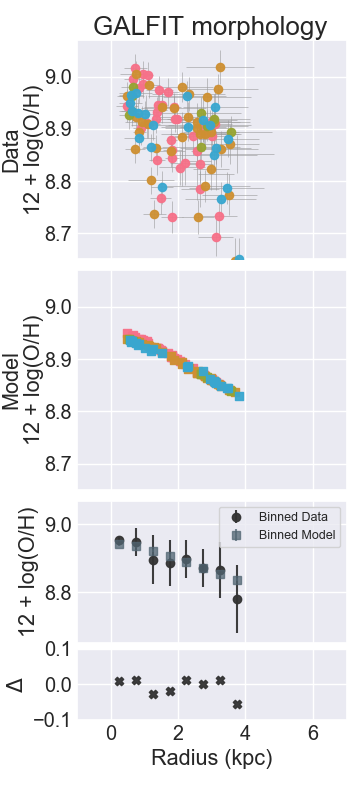

In [29]:
fig,ax0,ax1,ax20,ax21 = simpler_plot(obs,best_model_fixed_morph,residuals_fixed_morph)
fig.suptitle('GALFIT morphology',x=0.6,y=0.98)
fig.savefig('../../Plots/A370_1d_galfit.pdf')

<IPython.core.display.Javascript object>


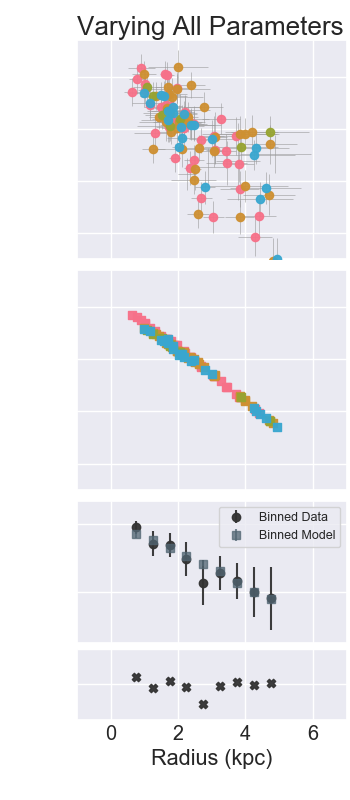

In [30]:
fig,ax0,ax1,ax20,ax21 = simpler_plot(obs,best_model,residuals)
ax0.set_ylabel('')
ax1.set_ylabel('')
ax20.set_ylabel('')
ax21.set_ylabel('')
ax0.tick_params(labelleft=False) 
ax1.tick_params(labelleft=False) 
ax20.tick_params(labelleft=False) 
ax21.tick_params(labelleft=False) 
fig.suptitle('Varying All Parameters',x=0.6,y=0.98)
fig.savefig('../../Plots/A370_1d_all_free.pdf')

## 2D Residuals

In [17]:
## Data for Correlation
mass_density_map = fits.getdata('Maps/Map_mass_density.fits')
mass_density_map_unc = fits.getdata('Maps/Map_mass_density_unc.fits')
sfr_density_map = fits.getdata('Maps/Map_SFR_density_Hb.fits')
sfr_density_map_unc = fits.getdata('Maps/Map_SFR_density_Hb_unc.fits')
voronoi_map = fits.getdata('Maps/Map_bins_SN_110_flux_stddev.fits')
voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]

# Scatter plot
def measure_in_vbins(im):
    return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])

# Metallicity
res_vbin =  measure_in_vbins(residuals)
res_morph_vbin = measure_in_vbins(residuals_fixed_morph)

dmass_vbin  = measure_in_vbins(mass_density_map) 
dmass_vbin_unc  = measure_in_vbins(mass_density_map_unc) 

dsfr_vbin    = measure_in_vbins(sfr_density_map)
dsfr_vbin_unc= measure_in_vbins(sfr_density_map_unc)

<IPython.core.display.Javascript object>


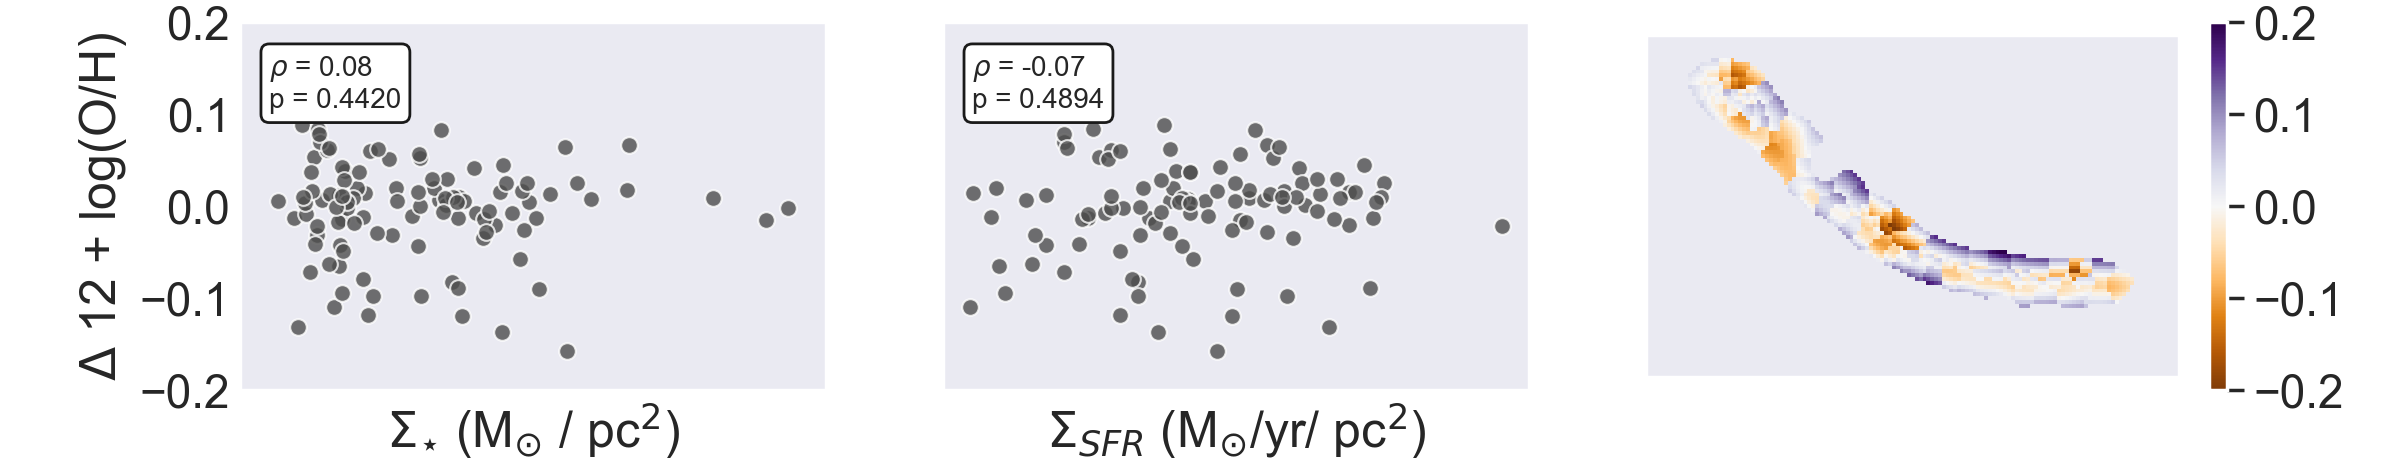

In [19]:
from scipy.stats import spearmanr

sns.set(font_scale=1.5)
sns.set_style('dark')

fig, ax = plt.subplots(1,3,figsize=(12,2.3))
fig.subplots_adjust(left=0.1,right=0.93,top=0.95,bottom=0.15)
ax = ax.ravel()

mass_color = '0.3'
sfr_color = '0.3'
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)

# Model free
cax = ax[2].imshow(residuals,cmap='PuOr',vmin=-0.2,vmax=0.2,origin='lower')
plt.colorbar(cax,ax=ax[2],orientation='vertical',fraction=0.04)
sns.scatterplot(dmass_vbin,res_vbin,ax=ax[1],color=mass_color,alpha=0.8)
sns.scatterplot(dsfr_vbin,res_vbin,ax=ax[0],color=sfr_color,alpha=0.8)
ax[0].annotate('$\\rho$ = %0.2f\np = %0.4f'%spearmanr(dmass_vbin,res_vbin),
            xy=(0.05, 0.77), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
ax[1].annotate('$\\rho$ = %0.2f\np = %0.4f'%spearmanr(dsfr_vbin,res_vbin),
            xy=(0.05, 0.77), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)     

# Titles and legends
ax[0].tick_params(labelbottom=False,direction='in') 
ax[1].tick_params(labelbottom=False,labelleft=False,direction='in') 
ax[2].tick_params(labelbottom=False,labelleft=False)
ax[0].set_ylabel('$\Delta$ 12 + log(O/H)')
ax[0].set_ylim(-0.2,0.2)
ax[1].set_ylim(-0.2,0.2)

ax[0].set_xlabel('$\Sigma_{\star}$ (M$_{\odot}$ / pc$^{2}$)')
ax[1].set_xlabel('$\Sigma_{SFR}$ (M$_{\odot}$/yr/ pc$^{2}$)')

fig.savefig('../../Plots/A370_residuals.pdf')

<IPython.core.display.Javascript object>


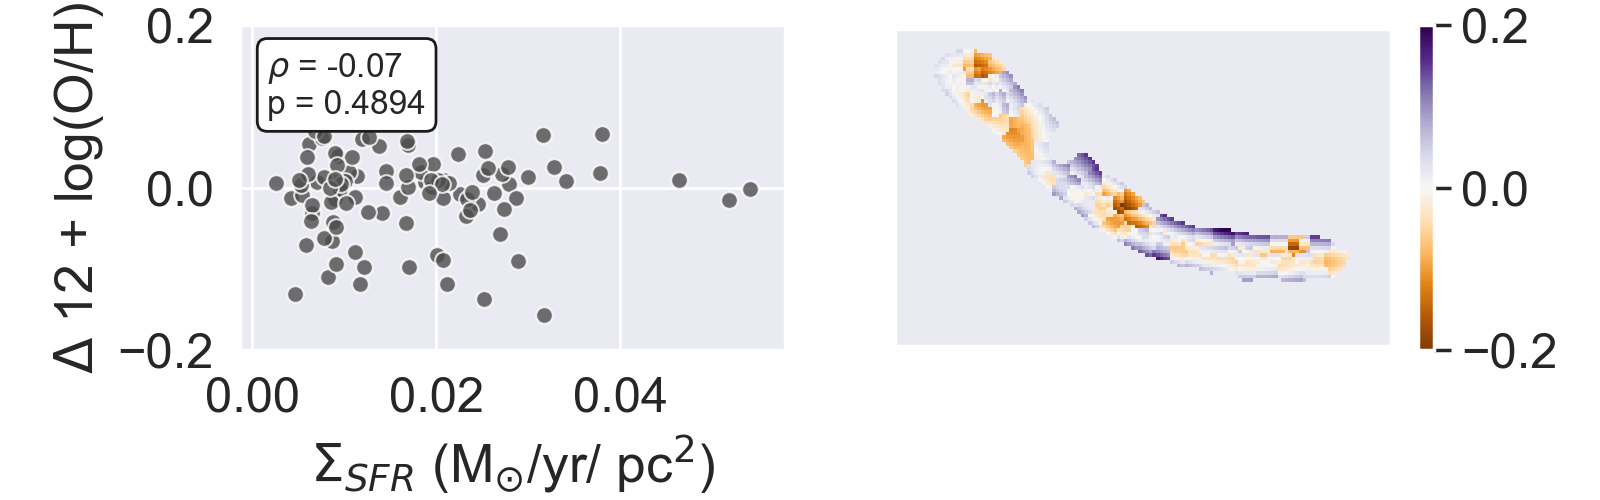

In [40]:
from scipy.stats import spearmanr
sns.set(font_scale=1.6)
fig, ax = plt.subplots(1,2,figsize=(8.0,2.5))
fig.subplots_adjust(left=0.15,right=0.90,top=0.95,bottom=0.30)
ax = ax.ravel()

mass_color = '0.3'
sfr_color = '0.3'
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)

# Model free
cax = ax[1].imshow(residuals,cmap='PuOr',vmin=-0.2,vmax=0.2,origin='lower')
plt.colorbar(cax,ax=ax[1],orientation='vertical',fraction=0.04)
sns.scatterplot(dsfr_vbin,res_vbin,ax=ax[0],color=sfr_color,alpha=0.8)
ax[0].annotate('$\\rho$ = %0.2f\np = %0.4f'%spearmanr(dsfr_vbin,res_vbin),
            xy=(0.05, 0.73), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=12)    

# Titles and legends
#ax[0].tick_params(labelbottom=False,direction='in') 
ax[1].tick_params(labelbottom=False,labelleft=False)
ax[0].set_ylabel('$\Delta$ 12 + log(O/H)')
ax[0].set_ylim(-0.2,0.2)
ax[1].grid(False)

ax[0].set_xlabel('$\Sigma_{SFR}$ (M$_{\odot}$/yr/ pc$^{2}$)')

fig.savefig('../../Plots/A370_residuals_v2.pdf')

<IPython.core.display.Javascript object>


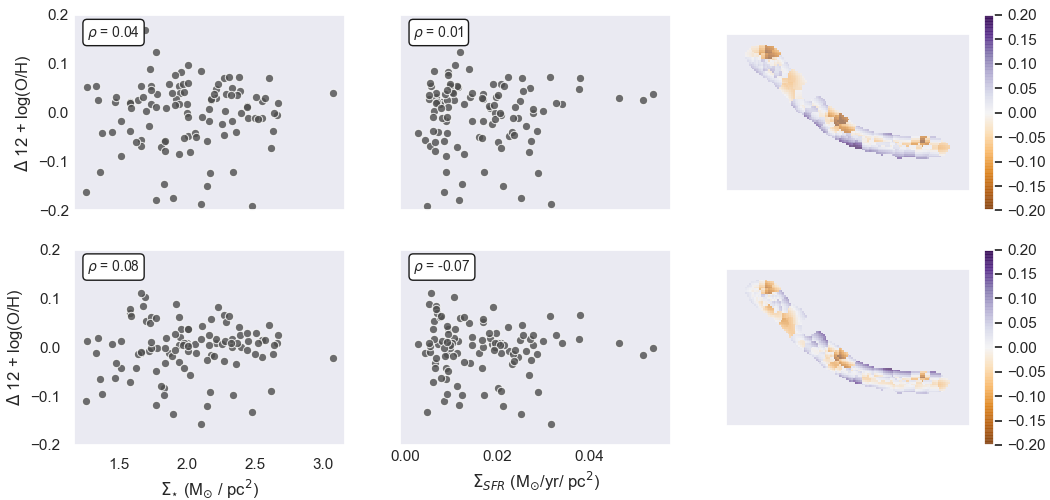

In [20]:
from scipy.stats import spearmanr
sns.set_style('dark')
fig, ax = plt.subplots(2,3,figsize=(10.5,5))
fig.subplots_adjust(left=0.07,right=0.95,top=0.97)
ax = ax.ravel()

mass_color = '0.3'
sfr_color = '0.3'
cmap_met = sns.cubehelix_palette(start=3, light=0.95, as_cmap=True)
bbox_props = dict(boxstyle="round", fc='w',ec="k", alpha=1)

# Model with fixed morphology

#ax[2].countour(hst_test,cmap='Greys',vmin=0,vmax=0.3,origin='lower')
cax = ax[2].imshow(residuals_fixed_morph,cmap='PuOr',vmin=-0.2,vmax=0.2,origin='lower',alpha=0.6)
plt.colorbar(cax,ax=ax[2],orientation='vertical',fraction=0.05)
sns.scatterplot(dmass_vbin,res_morph_vbin,ax=ax[0],color=mass_color,alpha=0.8)
sns.scatterplot(dsfr_vbin,res_morph_vbin,ax=ax[1],color=sfr_color,alpha=0.8)
ax[0].annotate('$\\rho$ = %0.2f'%spearmanr(dmass_vbin,res_morph_vbin)[0],
            xy=(0.05, 0.89), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
ax[1].annotate('$\\rho$ = %0.2f'%spearmanr(dsfr_vbin,res_morph_vbin)[0],
            xy=(0.05, 0.89), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10) 

# Model free
#ax[5].imshow(hst_test,cmap='Greys',vmin=0,vmax=0.3,origin='lower')
cax = ax[5].imshow(residuals,cmap='PuOr',vmin=-0.2,vmax=0.2,origin='lower',alpha=0.6)
plt.colorbar(cax,ax=ax[5],orientation='vertical',fraction=0.05)
sns.scatterplot(dmass_vbin,res_vbin,ax=ax[3],color=mass_color,alpha=0.8)
sns.scatterplot(dsfr_vbin,res_vbin,ax=ax[4],color=sfr_color,alpha=0.8)
ax[3].annotate('$\\rho$ = %0.2f'%spearmanr(dmass_vbin,res_vbin)[0],
            xy=(0.05, 0.89), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)
ax[4].annotate('$\\rho$ = %0.2f'%spearmanr(dsfr_vbin,res_vbin)[0],
            xy=(0.05, 0.89), xycoords='axes fraction',bbox=bbox_props,zorder=20,fontsize=10)    

# Titles and legends
ax[0].tick_params(labelbottom=False,direction='in') 
ax[1].tick_params(labelbottom=False,labelleft=False,direction='in') 
ax[4].tick_params(labelleft=False,direction='in') 
ax[2].tick_params(labelbottom=False,labelleft=False)
ax[5].tick_params(labelbottom=False,labelleft=False) 
ax[0].set_ylabel('$\Delta$ 12 + log(O/H)')
ax[3].set_ylabel('$\Delta$ 12 + log(O/H)')
ax[0].set_ylim(-0.2,0.2)
ax[1].set_ylim(-0.2,0.2)
ax[3].set_ylim(-0.2,0.2)
ax[4].set_ylim(-0.2,0.2)
ax[3].set_xlabel('$\Sigma_{\star}$ (M$_{\odot}$ / pc$^{2}$)')
ax[4].set_xlabel('$\Sigma_{SFR}$ (M$_{\odot}$/yr/ pc$^{2}$)')

fig.savefig('../../Plots/A370_residuals-both.pdf')

In [ ]:
## 

In [7]:
def measure_in_vbins(im,stat):
    if stat == 'mean':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])
    if stat == 'std':
        return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[2] for v in bins ])

def bin_data_r(data,dist):
    binned_data, bin_edges, bin_number = binned_statistic(dist,data,'mean',bins=range(0,20))
    binned_err, bin_edges, bin_number = binned_statistic(dist,data,'std',bins=range(0,20))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

def bin_data_ang(data,ang):
    binned_data, bin_edges, bin_number = binned_statistic(ang,data,'mean',bins=range(0,360,20))
    binned_err, bin_edges, bin_number = binned_statistic(ang,data,'std',bins=range(0,360,20))
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    return binned_data, binned_err, bin_centers

In [8]:
voronoi_map = fits.getdata('Maps/Map_bins_SN_110_flux_stddev.fits')
voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]
size_vbin   = np.array([len(np.atleast_1d(np.where(voronoi_map==v)[0])) for v in bins ])

mult_map = fits.getdata('multiple_regions_mask.fits')
reg_vbin = np.array([sigma_clipped_stats(mult_map[np.where(voronoi_map==v)])[0] for v in np.unique(voronoi_map) ])[1:]

In [114]:
colors = sns.color_palette("husl", 8)
c_head,c_reg1,c_reg2,c_reg3 = colors[0], colors[1], colors[2], colors[5]

def set_figure():
    
    fig, ax = plt.subplots(3,2,figsize=(6,8))
    fig.subplots_adjust(top=0.98,left=0.13,right=0.99,wspace=0.02,hspace=0.05,bottom=0.06)
    ax = ax.ravel()
    gs4 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[4],height_ratios=[2,1])
    gs40 = plt.Subplot(fig, gs4[0])
    fig.add_subplot(gs40)
    gs41 = plt.Subplot(fig, gs4[1])
    fig.add_subplot(gs41)
    ax[4].axis('off')
    gs5 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax[5],height_ratios=[2,1])
    gs50 = plt.Subplot(fig, gs5[0])
    fig.add_subplot(gs50)
    gs51 = plt.Subplot(fig, gs5[1])
    fig.add_subplot(gs51)
    ax[5].axis('off')
    return fig,ax,gs40,gs41,gs50,gs51

def set_axis(ax,gs40,gs41,gs50,gs51):
    
    ax[0].set_ylim(8.65,9.07)
    ax[2].set_ylim(8.65,9.07)
    gs40.set_ylim(8.65,9.07)
    ax[1].set_ylim(8.65,9.07)
    ax[3].set_ylim(8.65,9.07)
    gs50.set_ylim(8.65,9.07)
    gs41.set_ylim(-0.1,0.1)
    gs51.set_ylim(-0.1,0.1)
    ax[0].set_xlim(-1,20)
    ax[2].set_xlim(-1,20)
    gs40.set_xlim(-1,20)
    gs41.set_xlim(-1,20)
    ax[1].set_xlim(-20,390)
    ax[3].set_xlim(-20,390)
    gs50.set_xlim(-20,390)
    gs51.set_xlim(-20,390)

    ax[0].set_ylabel('Data\n12 + log(O/H)')
    ax[2].set_ylabel('Model\n12 + log(O/H)')
    gs40.set_ylabel('12 + log(O/H)')
    gs41.set_ylabel('$\Delta$')

    gs41.set_xlabel('Radius (kpc)')
    gs51.set_xlabel('$\Theta$ (deg)')

    ax[0].tick_params(labelbottom=False,direction='in')    
    ax[2].tick_params(labelbottom=False,direction='in')  
    ax[1].tick_params(labelbottom=False,direction='in',labelleft=False)    
    ax[3].tick_params(labelbottom=False,direction='in',labelleft=False)
    gs50.tick_params(labelbottom=False,direction='in',labelleft=False) 
    gs51.tick_params(direction='in',labelleft=False) 
    gs41.tick_params(direction='in') 
    

def plot(obs,model,res):
    
    fig,ax,gs40,gs41,gs50,gs51 = set_figure()
    set_axis(ax,gs40,gs41,gs50,gs51)
        
    # Metallicity
    met_vbin     = measure_in_vbins(obs.data,'mean')
    emet_vbin    = measure_in_vbins(obs.unc,'mean')
    met_vbin_std = measure_in_vbins(obs.data,'std') 
    met_vbin_err = np.sqrt(emet_vbin**2 + met_vbin_std**2)

    # Model
    model.conv_data
    model_vbin     = measure_in_vbins( model.conv_data,'mean')
    model_vbin_std = measure_in_vbins( model.conv_data,'std')

    # Residuals
    res_vbin = measure_in_vbins(res,'mean') 
    res_vbin = measure_in_vbins(res,'mean') 

    # Morphology
    distance_map = model.make_distance_map()
    dist_vbin     = measure_in_vbins(distance_map,'mean')
    dist_vbin_std = measure_in_vbins(distance_map,'std')
    angular_map = model.make_azimuthal_map()
    ang_vbin     = measure_in_vbins(angular_map,'mean')
    ang_std_vbin = measure_in_vbins(angular_map,'std')

    # Radial
    ax[0].errorbar(dist_vbin, met_vbin, xerr=dist_vbin_std, yerr=met_vbin_err, linestyle='', ecolor='0.6', elinewidth=0.4)
    for c,region,l in zip((c_head,c_reg1,c_reg2,c_reg3),range(1,5),('head','reg. 1','reg. 2','reg. 3')):
        pix = np.where(reg_vbin==region)
        ax[0].scatter(dist_vbin[pix],met_vbin[pix],linewidths=None,alpha=0.95,marker='.',color=c,s=size_vbin**1.7+20)
        ax[2].scatter(dist_vbin[pix],model_vbin[pix],linewidths=None,alpha=0.95,marker='s',c=c,s=size_vbin**1.2+10)
    
    # Azimuthal
    ax[1].errorbar(ang_vbin,met_vbin,xerr=ang_std_vbin,yerr=met_vbin_err,linestyle='',ecolor='0.6',elinewidth=0.4)
    for c,region in zip((c_head,c_reg1,c_reg2,c_reg3),range(1,5)):
        pix = np.where(reg_vbin==region)
        ax[1].scatter(ang_vbin[pix],met_vbin[pix],linewidths=None,alpha=0.85,marker='.',color=c,s=size_vbin**1.7+20,label=l)
        ax[3].scatter(ang_vbin[pix],model_vbin[pix],linewidths=None,alpha=0.85,marker='s',color=c,s=size_vbin**1.2+10)
    ax[1].legend(loc=4)

    # Radial residuals
    met_rbin, met_std_rbin, dist_rbin = bin_data_r(met_vbin,dist_vbin)
    model_rbin, model_std_rbin, dist_rbin = bin_data_r(model_vbin,dist_vbin)
    res_rbin = met_rbin - model_rbin
    gs40.errorbar(dist_rbin, met_rbin, yerr=met_std_rbin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Binned Data')
    gs40.errorbar(dist_rbin, model_rbin, yerr=model_std_rbin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Binned Model')
    gs41.scatter(dist_rbin, res_rbin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')
    gs40.legend(fontsize=9)

   
    ## Azimuthal Residuals 
    met_abin, met_std_abin, ang_abin = bin_data_ang(met_vbin,ang_vbin)
    model_abin, model_std_abin, ang_abin = bin_data_ang(model_vbin,ang_vbin)
    res_abin = met_abin - model_abin
    gs50.errorbar(ang_abin, met_abin, yerr=met_std_abin, linestyle='', alpha=0.95, marker='o',color='0.2',label='Data')
    gs50.errorbar(ang_abin, model_abin, yerr=model_std_abin, linestyle='', alpha=0.75, marker='s',color='#516572',label='Model')
    gs51.scatter(ang_abin, res_abin, linewidths=None, alpha=0.95, marker='X',color='0.2',label='Residuals')

    return fig

<IPython.core.display.Javascript object>


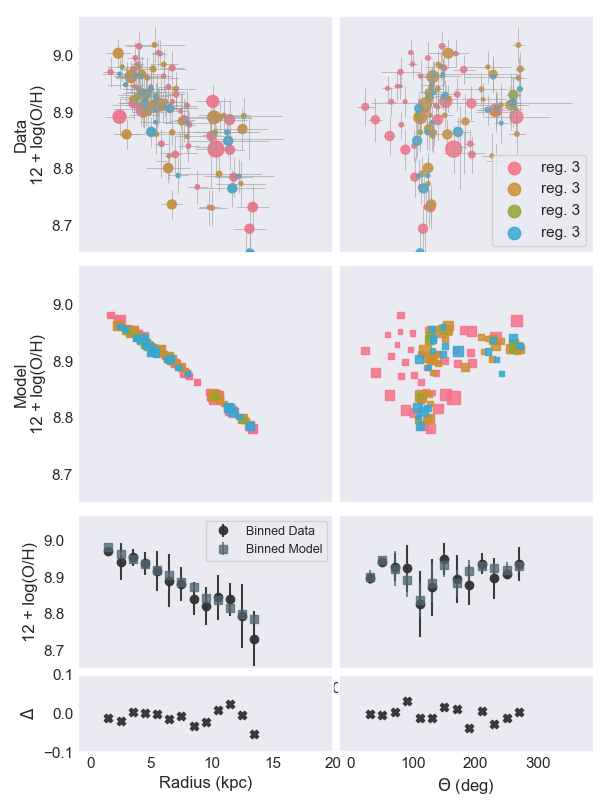

In [115]:
fig = plot(obs,best_model,residuals)

<IPython.core.display.Javascript object>


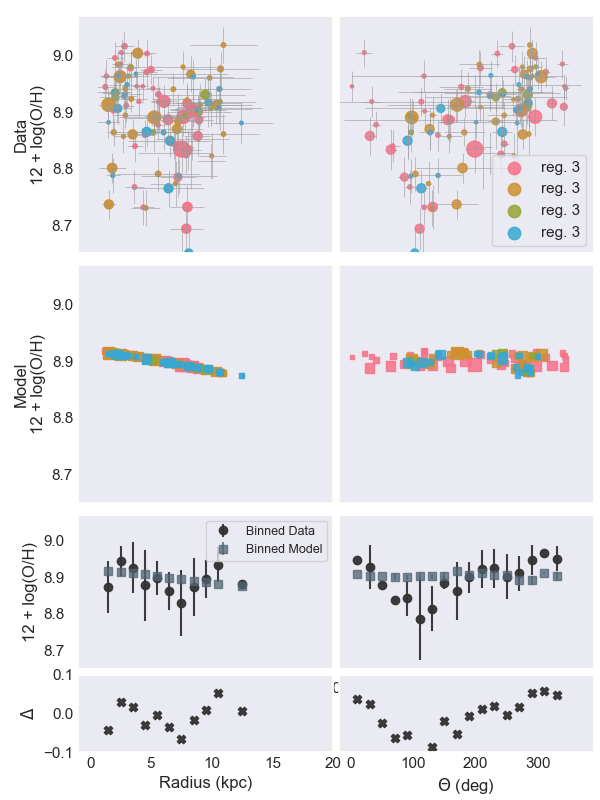

In [116]:
fig = plot(obs,best_model_hst,residuals_hst)

<IPython.core.display.Javascript object>


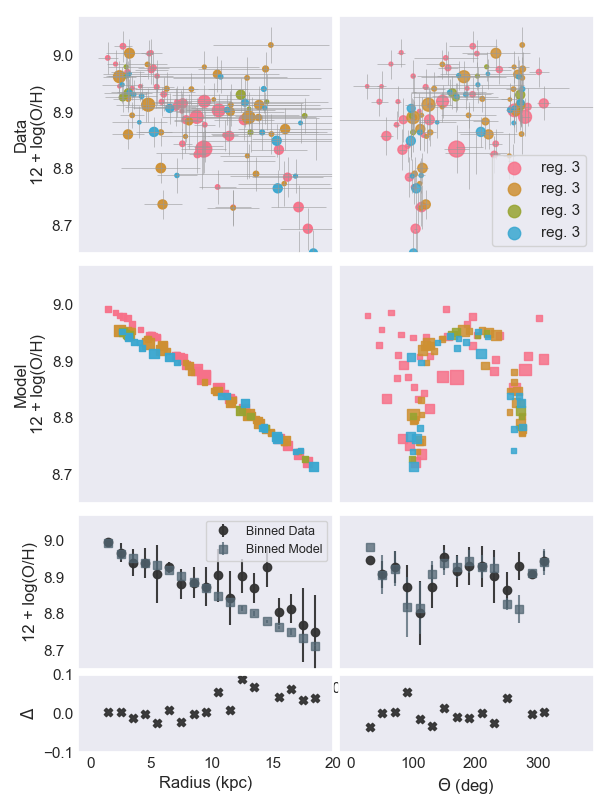

In [117]:
fig = plot(obs,best_model_head,residuals_head)